# 0.0 - IMPORTS

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import inflection
import locale
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
from IPython.display import Image
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from tabulate import tabulate

from scipy import stats as ss

## 0.1 Helper Funcitons 

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
pd.options.display.float_format = '{:,.2f}'.format

## 0.2 Loading Data 

In [5]:
df_train_raw = pd.read_csv('data/train.csv', low_memory=False)

# 1.0 - DATA DESCRIPTION

In [6]:
df1 = df_train_raw.copy()

## 1.1 Rename Columns 

In [7]:
cols_old = ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
            'Item_Type', 'Item_MRP', 'Outlet_Identifier',
            'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
            'Outlet_Type', 'Item_Outlet_Sales']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions 

In [8]:
print('Number of columns: {}'.format(df1.shape[1]))
print('Number of rows: {}'.format(df1.shape[0]))

Number of columns: 12
Number of rows: 8523


## 1.3 Data Types 

In [9]:
df1.dtypes

item_identifier               object
item_weight                  float64
item_fat_content              object
item_visibility              float64
item_type                     object
item_mrp                     float64
outlet_identifier             object
outlet_establishment_year      int64
outlet_size                   object
outlet_location_type          object
outlet_type                   object
item_outlet_sales            float64
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

item_identifier                 0
item_weight                  1463
item_fat_content                0
item_visibility                 0
item_type                       0
item_mrp                        0
outlet_identifier               0
outlet_establishment_year       0
outlet_size                  2410
outlet_location_type            0
outlet_type                     0
item_outlet_sales               0
dtype: int64

## 1.5 Fillout NA 

In [11]:
#========item_weight==============
#create aux item dataframe dataframe
aux1 = df1[['item_identifier', 'item_weight']].groupby(['item_identifier', 'item_weight']).max()
df_aux_item = pd.DataFrame(aux1).reset_index()

#merge aux item dataframe with df1
df1= pd.merge(df1, df_aux_item, how='left', on='item_identifier')
df1.drop('item_weight_x', inplace=True, axis=1)
df1 = df1.rename(columns={'item_weight_y': 'item_weight'})

#substitute NA left with mean products weight
mean_weight = df1['item_weight'].mean()
df1['item_weight'] = df1['item_weight'].fillna(mean_weight)

#============outlet_size=========== 
#replace outlet_identifier == OUT010 size for small based on similar OUT019
df1.loc[df1['outlet_identifier'] == 'OUT010', 'outlet_size'] = 'Small'

#replace outlet_identifier == OUT017 size for small based on similar majority for Supermarket Type1
df1.loc[df1['outlet_identifier'] == 'OUT017', 'outlet_size'] = 'Small'

#replace outlet_identifier == OUT045 size for small based on similar majority for Supermarket Type1
df1.loc[df1['outlet_identifier'] == 'OUT045', 'outlet_size'] = 'Small'

## 1.6 Change variables names

In [12]:
#============item_fat_content=========== 
#replace low fat to Low Fat
df1.loc[df1['item_fat_content'] == 'low fat', 'item_fat_content'] = 'Low Fat'

#replace LF to Low Fat
df1.loc[df1['item_fat_content'] == 'LF', 'item_fat_content'] = 'Low Fat'

#replace reg to Regular
df1.loc[df1['item_fat_content'] == 'reg', 'item_fat_content'] = 'Regular'

## 1.7 Descriptive Analytics 

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.7.1 Numerical Attributes 

In [14]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.mean)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [15]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,item_visibility,0.00,0.33,0.33,0.07,0.07,0.05,1.17,1.68
1,item_mrp,31.29,266.89,235.60,140.99,140.99,62.27,0.13,-0.89
2,outlet_establishment_year,"1,985.00","2,009.00",24.00,"1,997.83","1,997.83",8.37,-0.40,-1.21
3,item_outlet_sales,33.29,"13,086.96","13,053.67","2,181.29","2,181.29","1,706.40",1.18,1.62
4,item_weight,4.55,21.35,16.80,12.88,12.88,4.64,0.07,-1.23


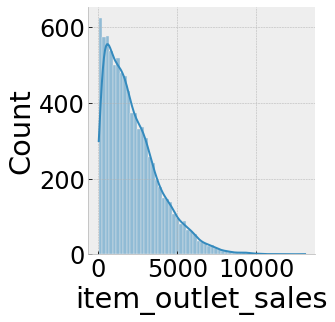

In [16]:
sns.displot(data=df1, x="item_outlet_sales", kde=True)
plt.show()

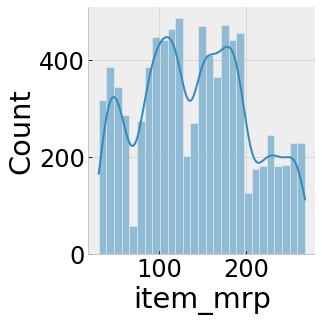

In [17]:
sns.displot(data=df1, x="item_mrp", kde=True)
plt.show()

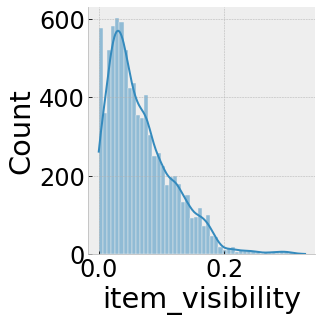

In [18]:
sns.displot(data=df1, x="item_visibility", kde=True)
plt.show()

### 1.7.2 Categorical Attributes 

In [19]:
cat_attributes.apply(lambda x: x.unique(). shape[0])

item_identifier         1559
item_fat_content           2
item_type                 16
outlet_identifier         10
outlet_size                3
outlet_location_type       3
outlet_type                4
dtype: int64

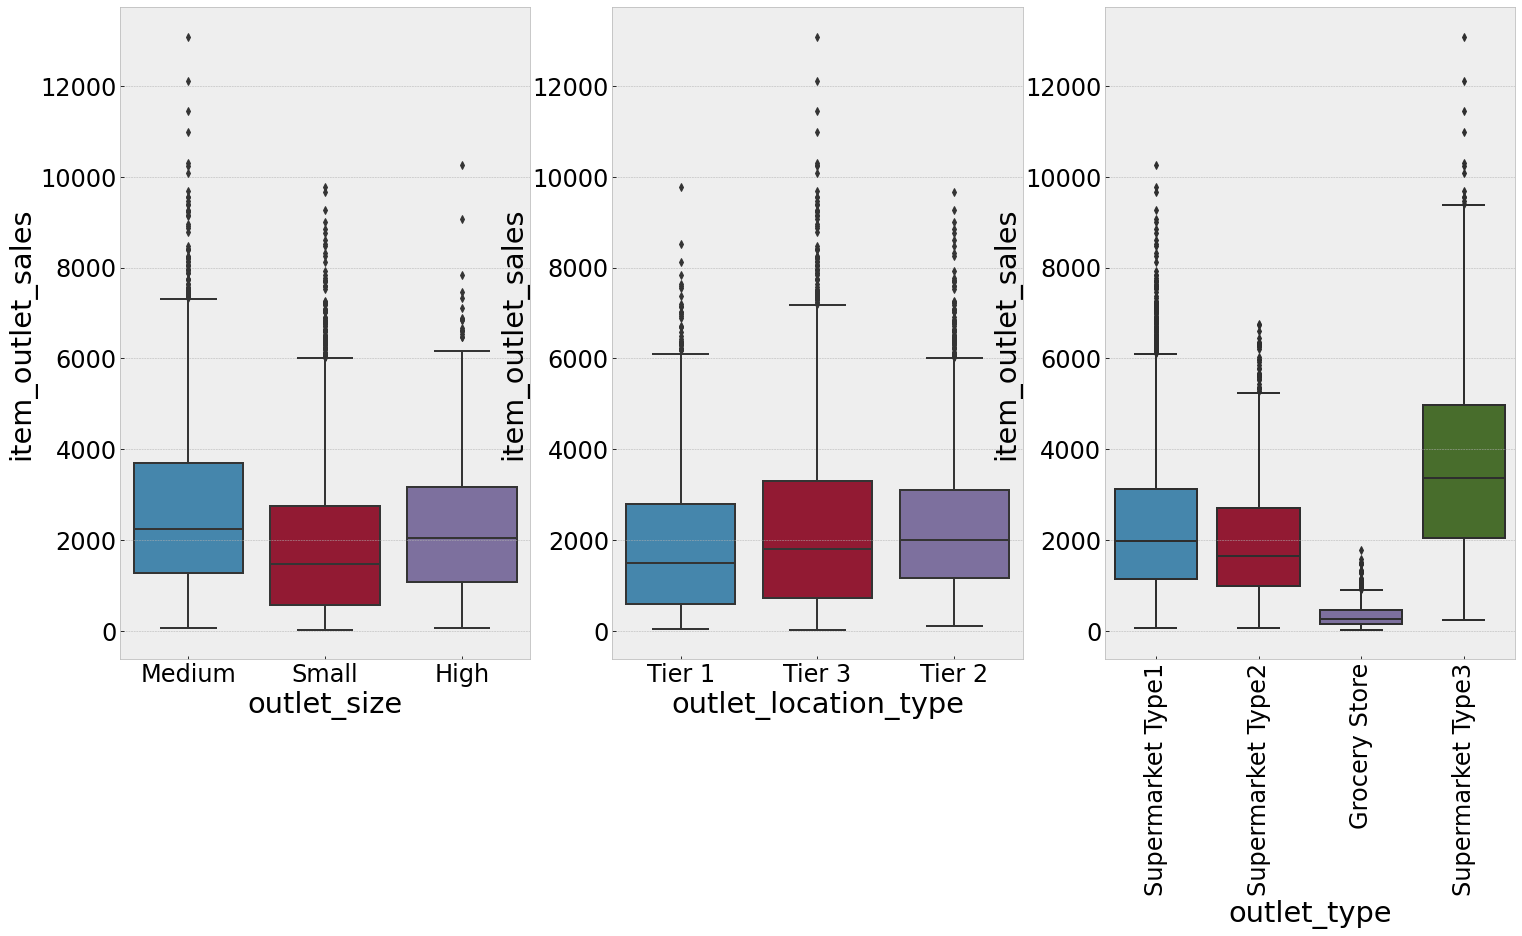

In [20]:
#==========outlet==============
plt.subplot(1,3,1)
sns.boxplot(x='outlet_size', y='item_outlet_sales', data=df1)

plt.subplot(1,3,2)
sns.boxplot(x='outlet_location_type', y='item_outlet_sales', data=df1)

plt.subplot(1,3,3)
sns.boxplot(x='outlet_type', y='item_outlet_sales', data=df1)
plt.xticks(rotation=90);

plt.show()

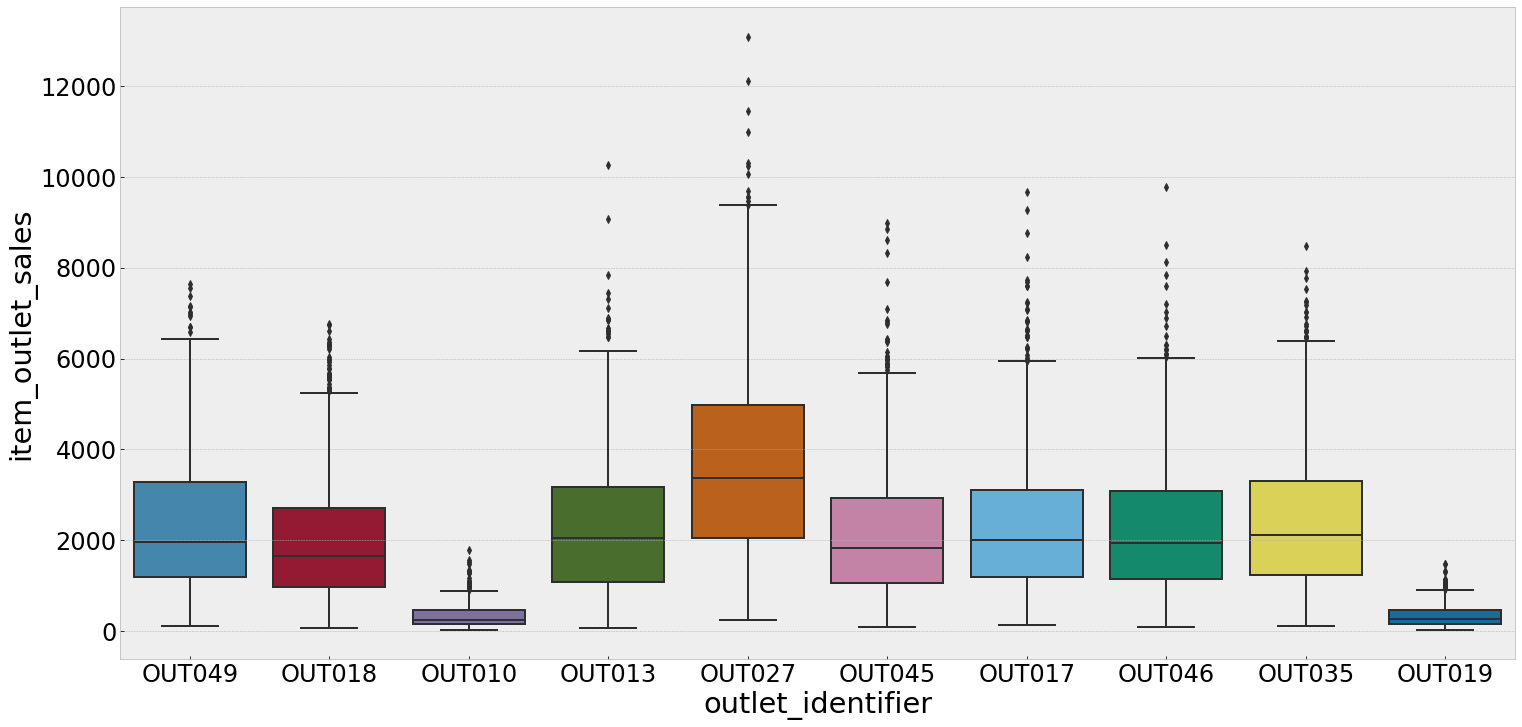

In [21]:
sns.boxplot(x='outlet_identifier', y='item_outlet_sales', data=df1)
plt.show()

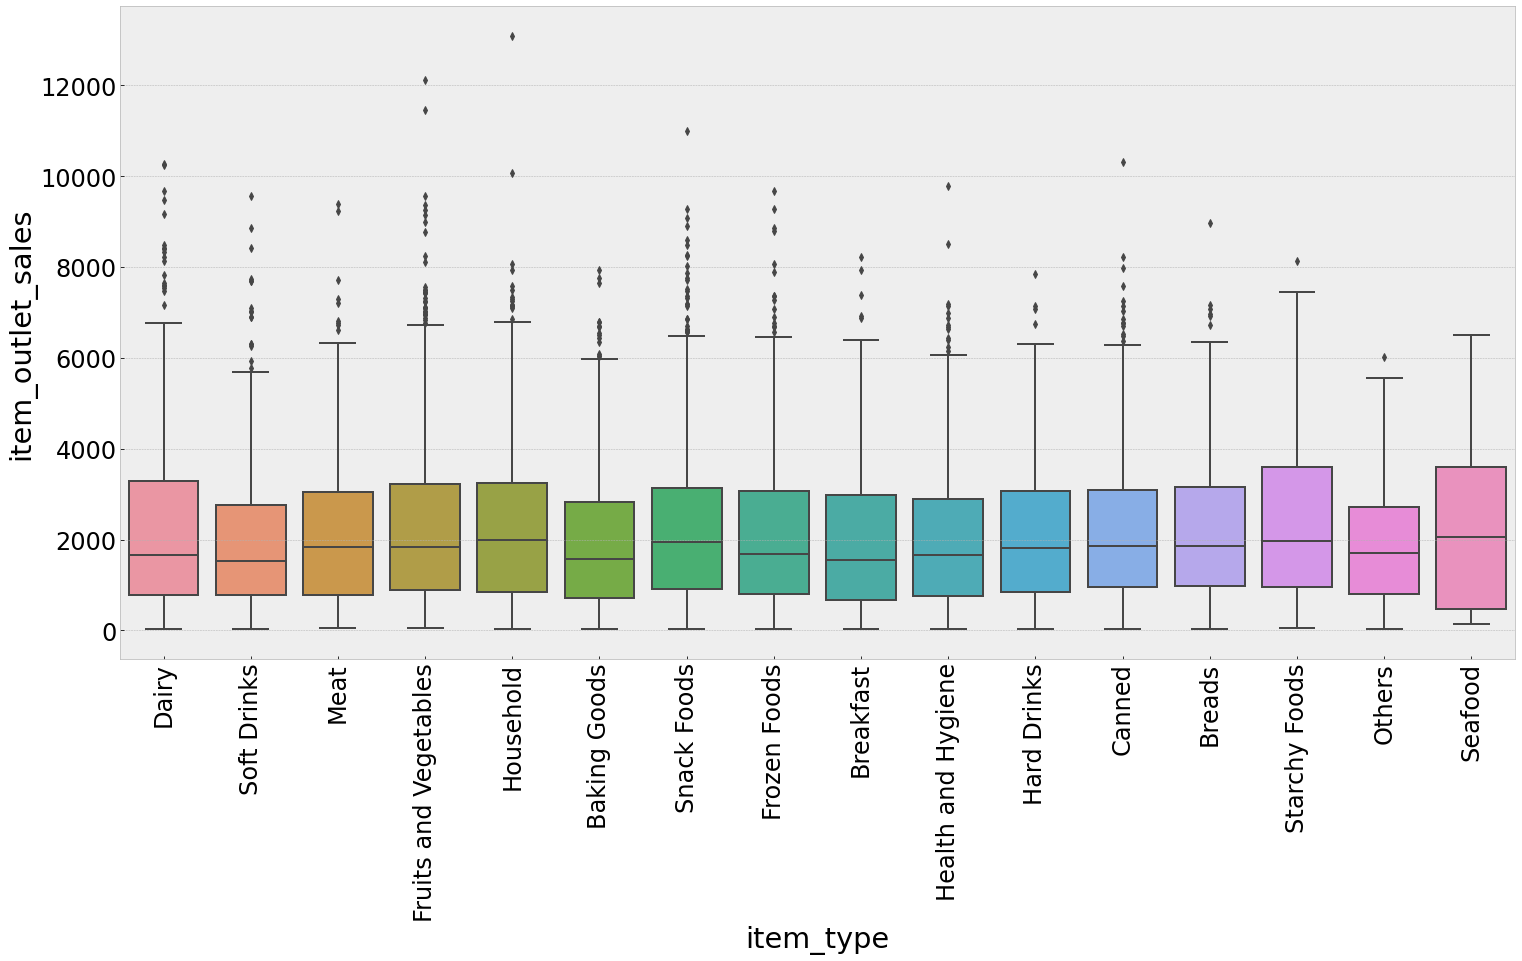

In [22]:
sns.boxplot(x='item_type', y='item_outlet_sales', data=df1)
plt.xticks(rotation=90);
plt.show()

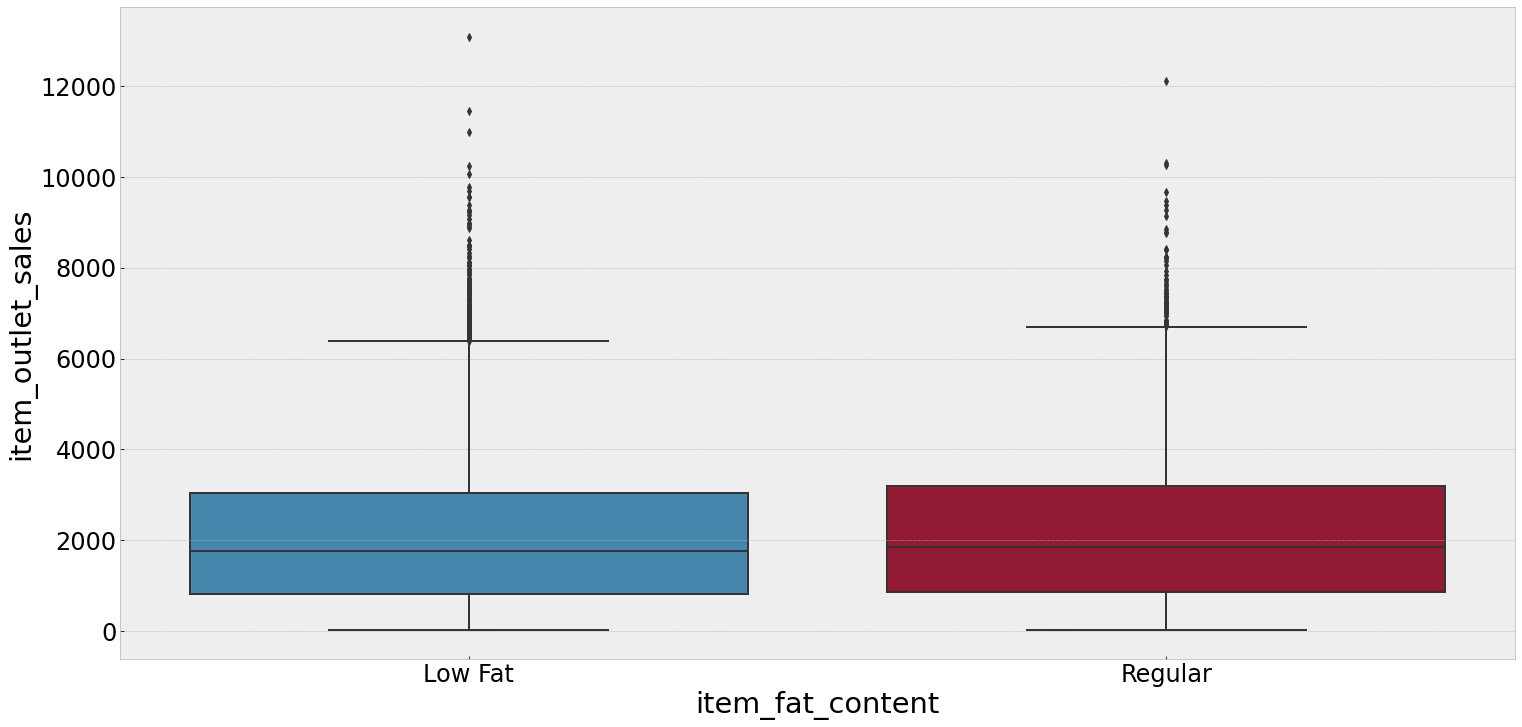

In [23]:
sns.boxplot(x='item_fat_content', y='item_outlet_sales', data=df1)
plt.show()

# 2.0 - FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map 

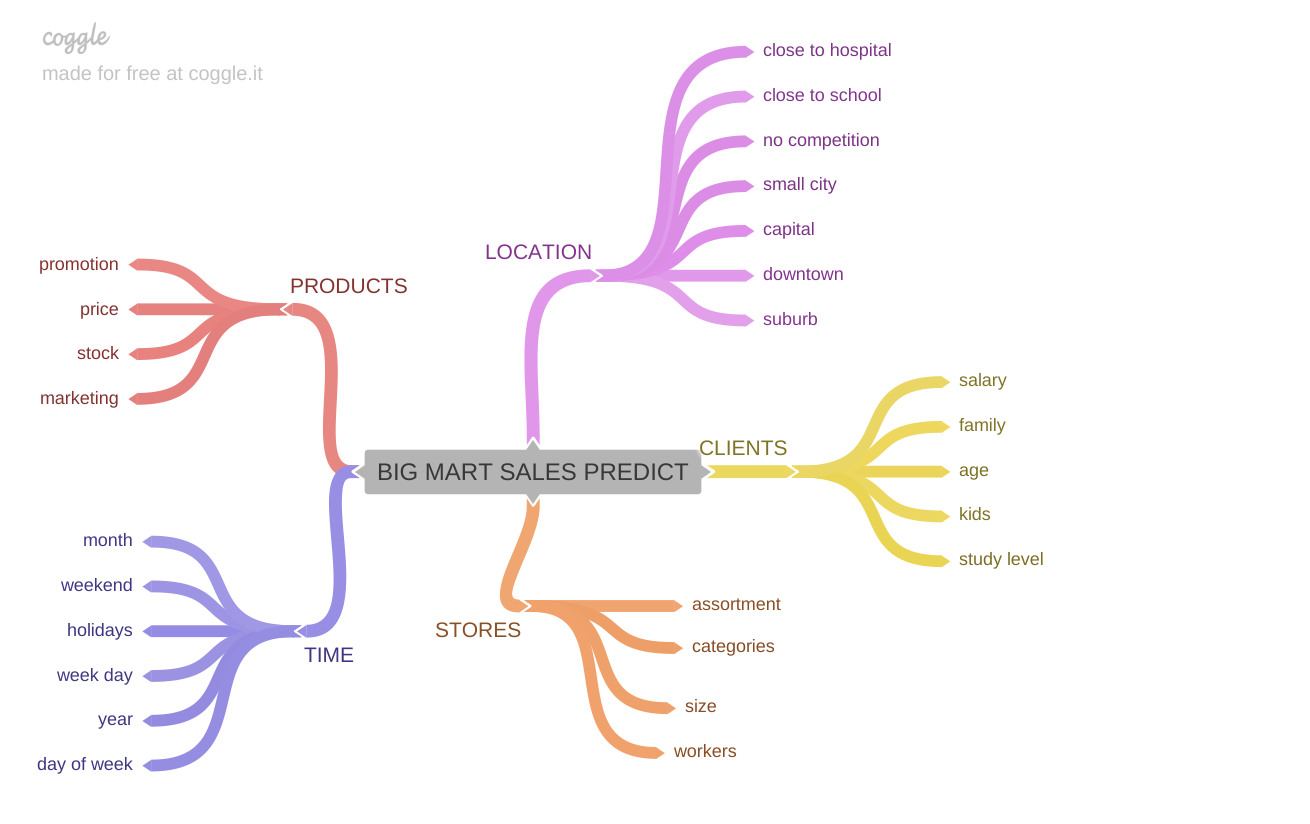

In [25]:
Image('img/mindmap.png')

## 2.2 Hypothesis 

### 2.1.1 Outlet hypothesis 

**H1** Bigger outlets should sell more.

**H2** Tier 3 location outlets shoul sell more.

**H3** Supermarket Type1 is the outlet type with more sales.

**H4** Older outlets should sell more.

### 2.1.2 Item hypothesis 

**H5** Regular fat items should sell more.

**H6** Items with bigger visibility should sell more.

**H7** Household items should be more expensive.

**H8** Expensive products should sell less.

**H9** Lighter items should cost less.

**H10** Heavier items should sell less.

### 2.1.3 Time hypothesis 

**H11** Outlets should sell more over the years.

**H12** Weekends should have less sales then weekdays.

**H13** Outlets should sell more in the last quarter of the year.

**H14** Items MRP should increase over the years.

**H15** Items visibility should increase over the years.

## 2.3 Final Hypothesis List 

**H1** Bigger outlets should sell more.

**H2** Tier 3 location outlets shoul sell more.

**H3** Supermarket Type1 is the outlet type with more sales.

**H4** Older outlets should sell more.

**H5** Regular fat items should sell more.

**H6** Items with bigger visibility should sell more.

**H7** Household items should be more expensive.

**H8** Expensive products should sell less.

**H9** Lighter items should cost less.

**H10** Heavier items should sell less.

**H11** Outlets should sell more over the years.

**H12** Items MRP should increase over the years.

**H13** Items visibility should increase over the years.

## 2.4 Feature Engineering 

In [26]:
#outlet_id
df2['outlet_id'] = df2['outlet_identifier'].str.extract(r'(\d{2}$)')

# 3.0 - EXPLORATION DATA ANALYSIS (EDA)

In [27]:
df3 = df2.copy()

## 3.1 Univariable Analysis 

### 3.1.1 Response Variable 

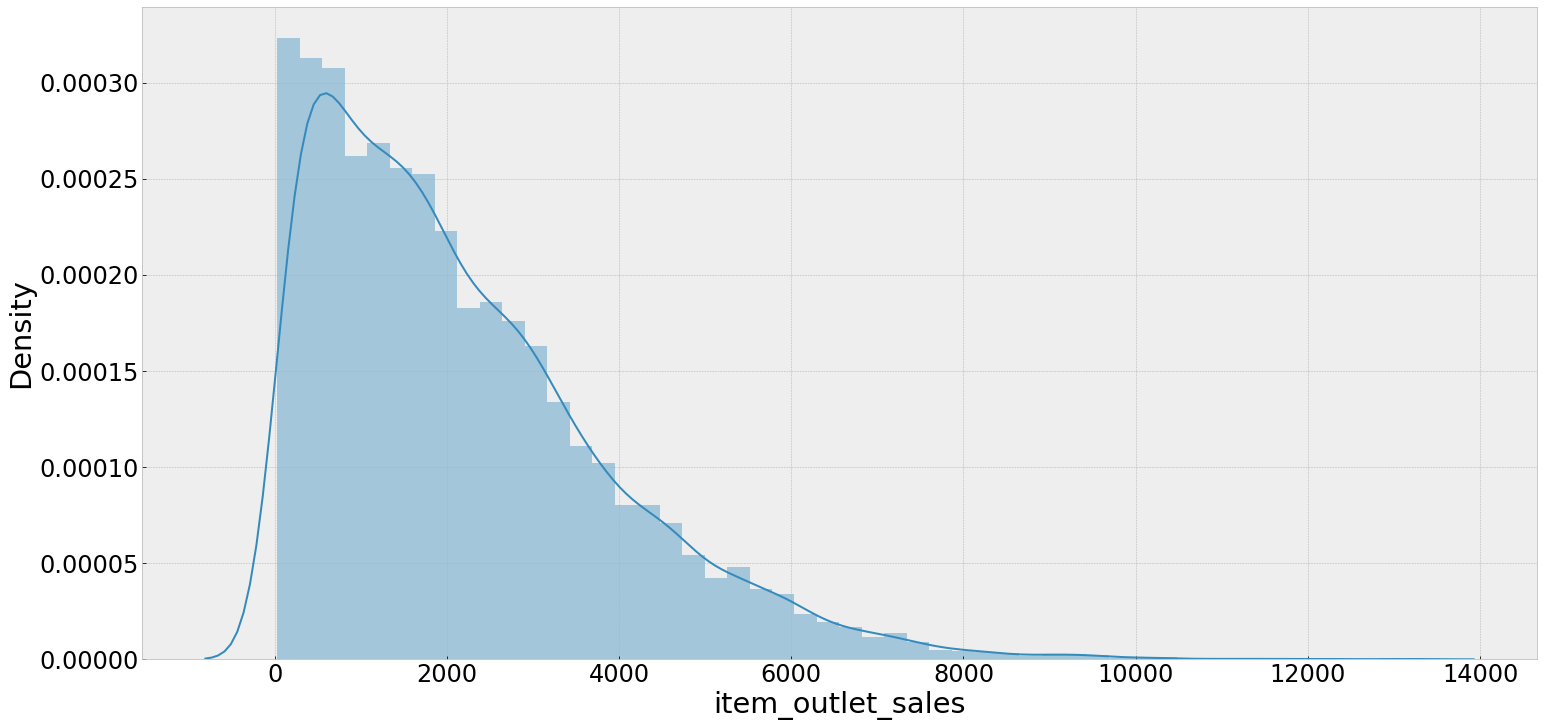

In [28]:
sns.distplot(df3['item_outlet_sales']);

### 3.1.2 Numerical Variables

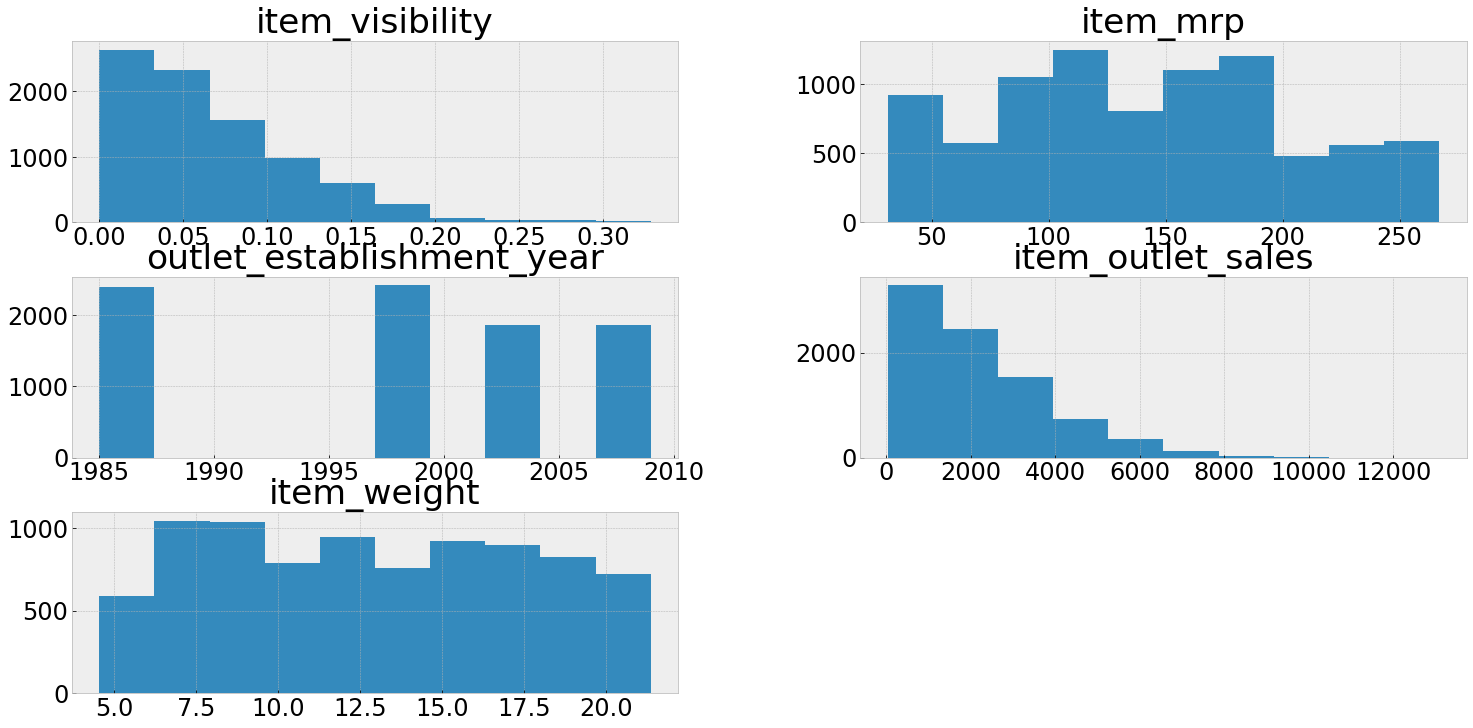

In [29]:
num_attributes.hist();

### 3.1.3 Categorical Variables 

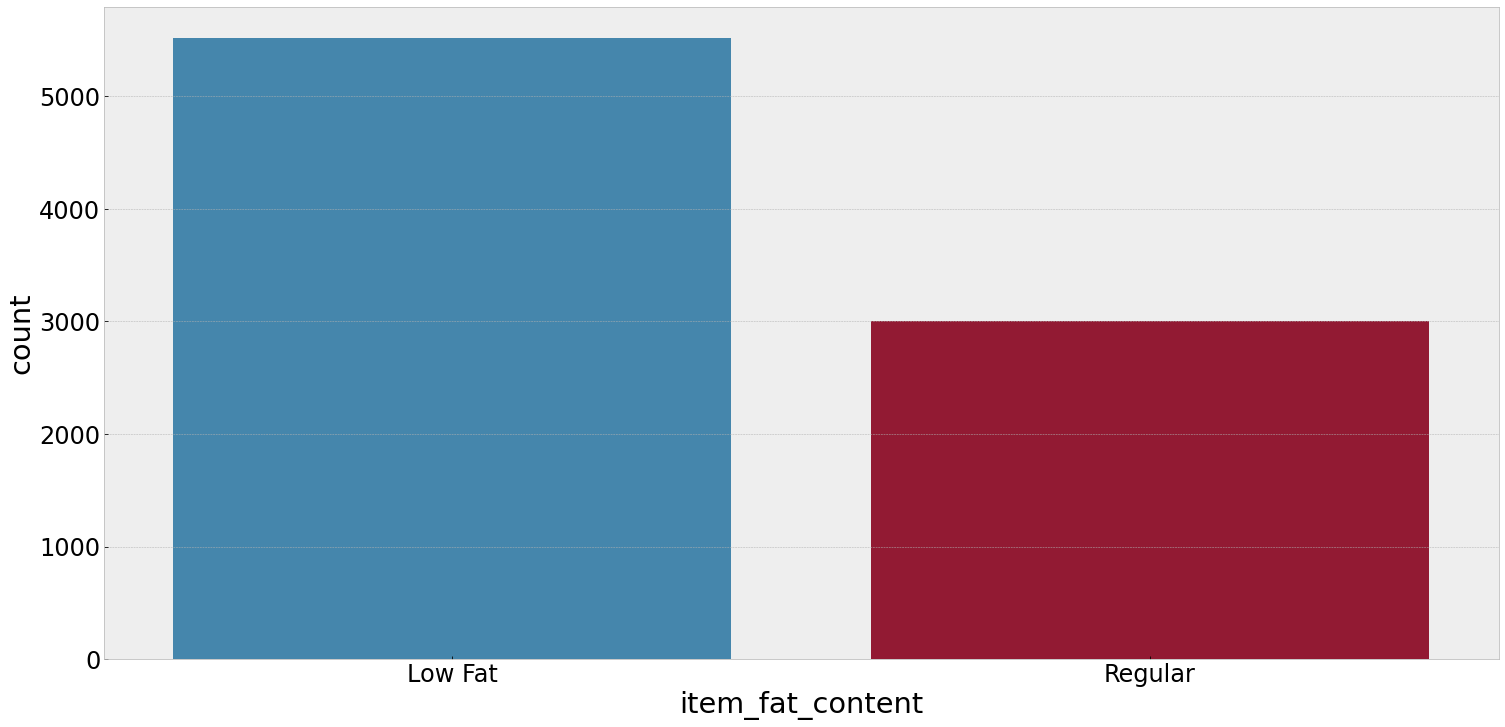

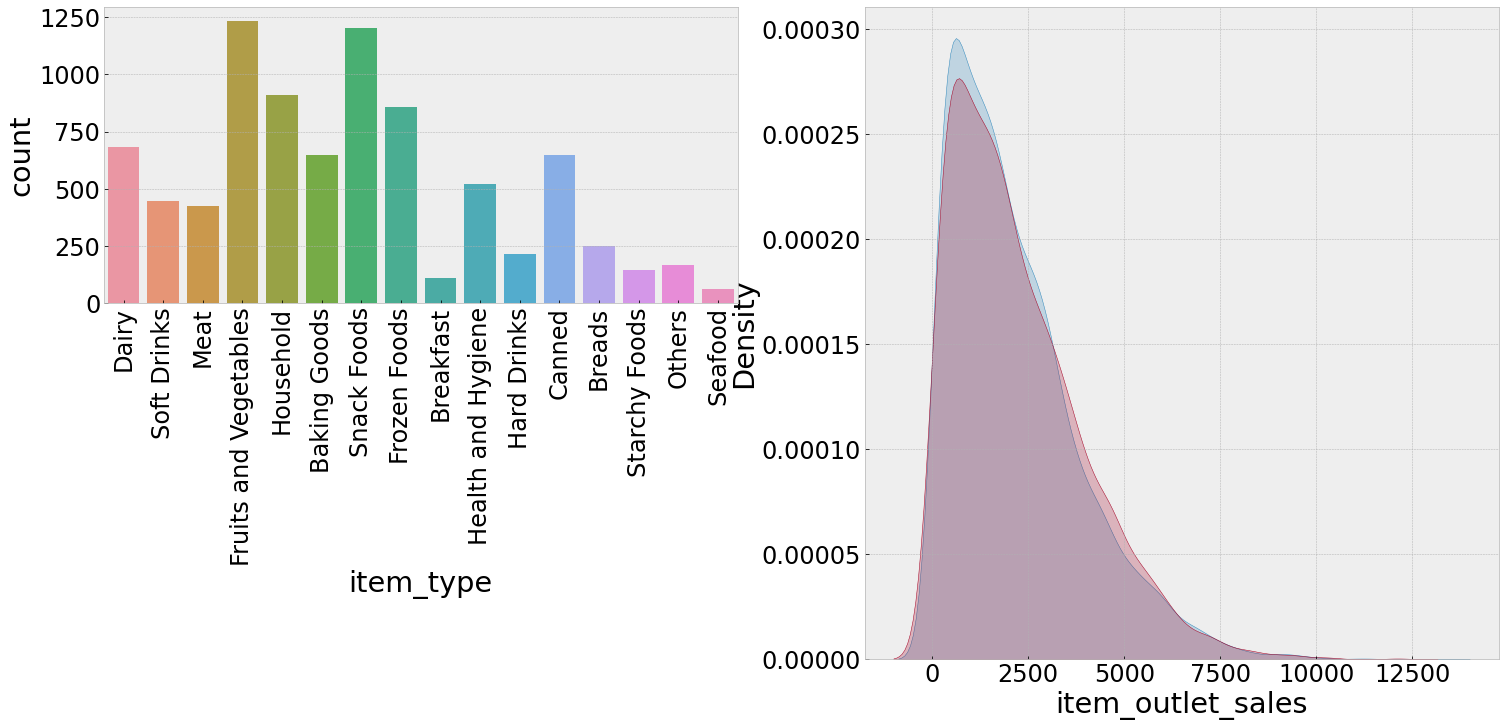

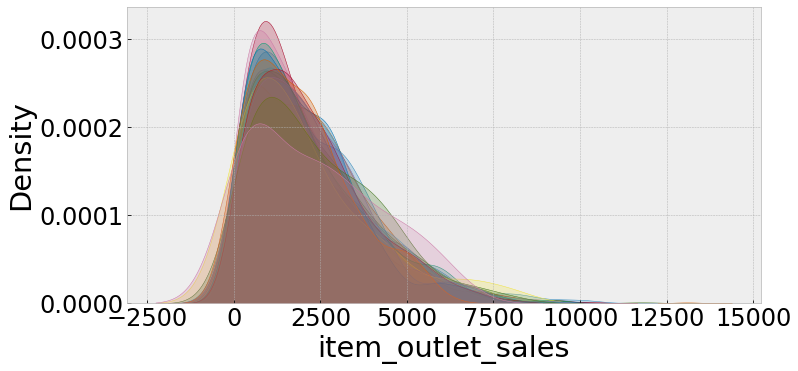

In [30]:
#item
plt.subplot(1, 1, 1)
sns.countplot(df3['item_fat_content']);
plt.show()

plt.subplot(1, 2, 2)
sns.kdeplot(df3[df3['item_fat_content'] == 'Low Fat']['item_outlet_sales'], label = 'Low Fat', shade=True);
sns.kdeplot(df3[df3['item_fat_content'] == 'Regular']['item_outlet_sales'], label = 'Regular', shade=True);

plt.subplot(2, 2, 1)
sns.countplot(df3['item_type']);
plt.xticks(rotation=90);
plt.show()

plt.subplot(2, 2, 2)
sns.kdeplot(df3[df3['item_type'] == 'Dairy']['item_outlet_sales'], label = 'Dairy', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Soft Drinks']['item_outlet_sales'], label = 'Soft Drinks', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Meat']['item_outlet_sales'], label = 'Meat', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Fruits and Vegetables']['item_outlet_sales'], label = 'Fruits and Vegetables', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Household']['item_outlet_sales'], label = 'Household', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Baking Goods']['item_outlet_sales'], label = 'Baking Goods', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Snack Foods']['item_outlet_sales'], label = 'Snack Foods', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Frozen Foods']['item_outlet_sales'], label = 'Frozen Foods', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Breakfast']['item_outlet_sales'], label = 'Breakfast', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Health and Hygiene']['item_outlet_sales'], label = 'Health and Hygiene', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Hard Drinks']['item_outlet_sales'], label = 'Hard Drinks', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Canned']['item_outlet_sales'], label = 'Canned', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Breads']['item_outlet_sales'], label = 'Breads', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Starchy Foods']['item_outlet_sales'], label = 'Starchy Foods', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Others']['item_outlet_sales'], label = 'Others', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Seafood']['item_outlet_sales'], label = 'Seafood', shade=True);

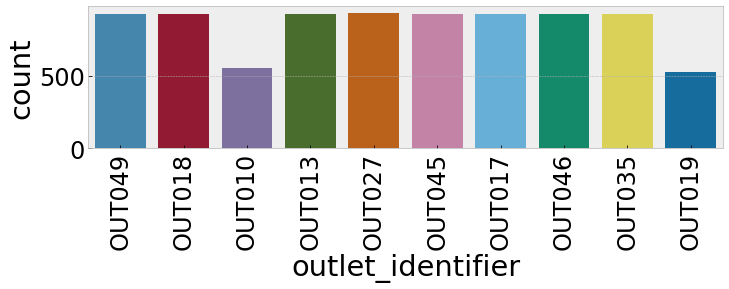

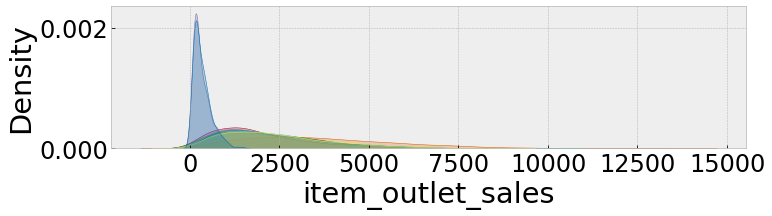

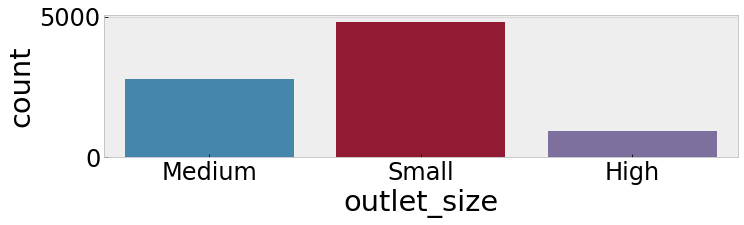

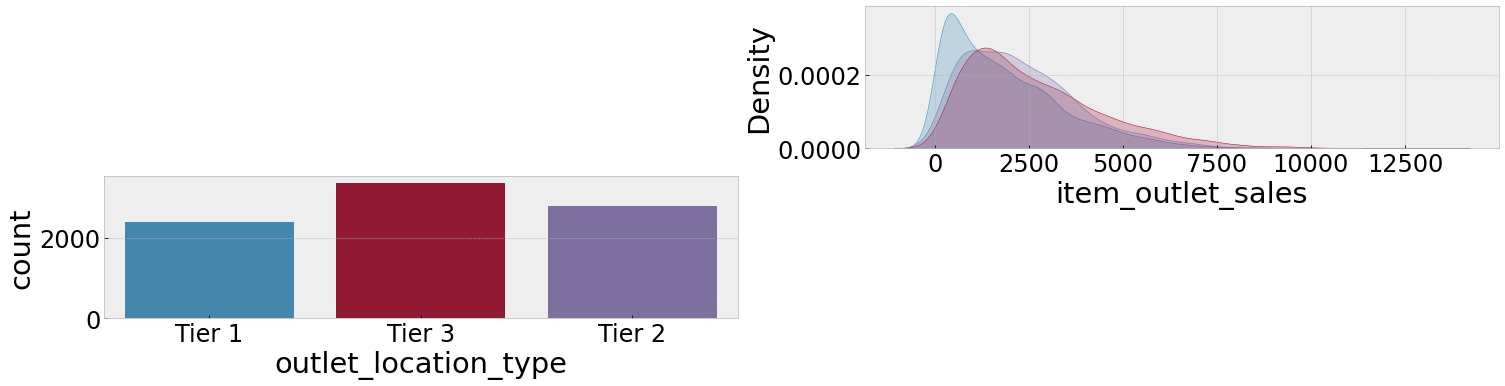

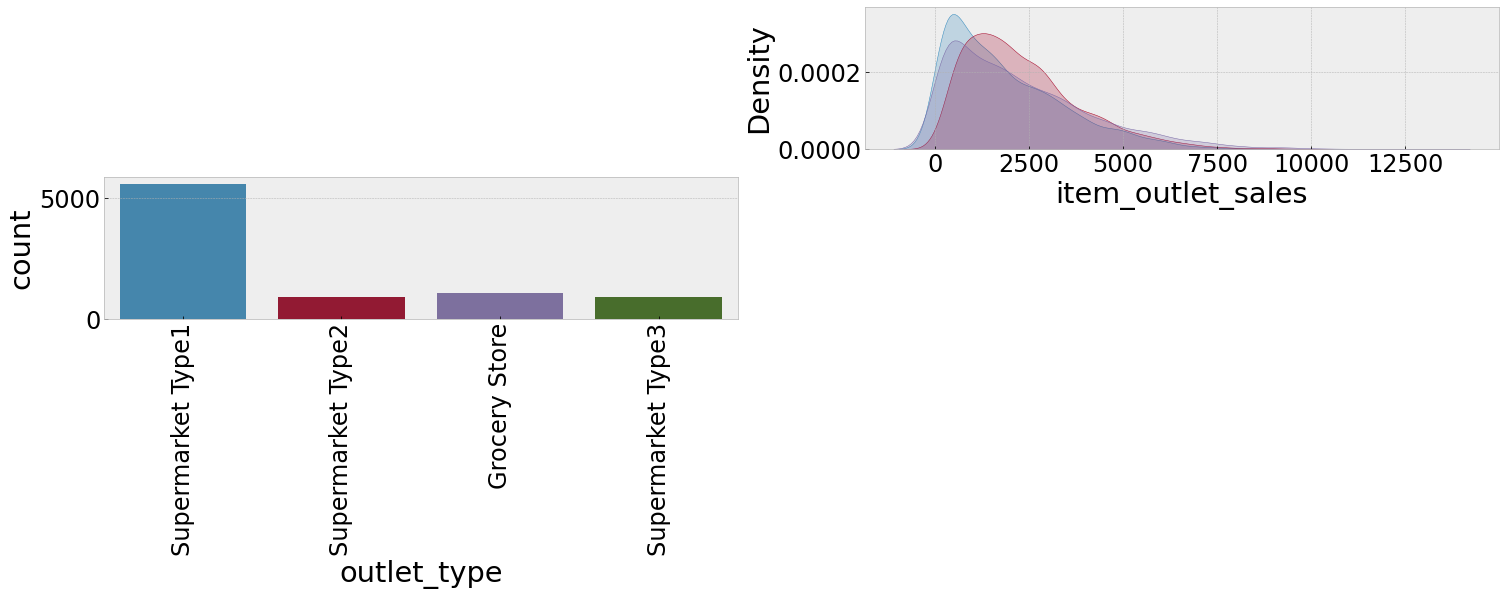

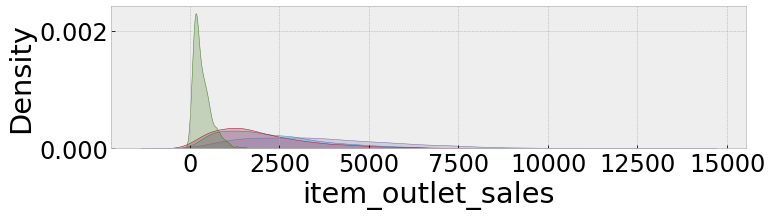

In [31]:
#outlet
plt.subplot(4, 2, 1)
sns.countplot(df3['outlet_identifier']);
plt.xticks(rotation=90);
plt.show()

plt.subplot(4, 2, 2)
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT049']['item_outlet_sales'], label = 'OUT049', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT018']['item_outlet_sales'], label = 'OUT018', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT010']['item_outlet_sales'], label = 'OUT010', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT013']['item_outlet_sales'], label = 'OUT013', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT027']['item_outlet_sales'], label = 'OUT027', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT045']['item_outlet_sales'], label = 'OUT045', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT017']['item_outlet_sales'], label = 'OUT017', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT046']['item_outlet_sales'], label = 'OUT046', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT035']['item_outlet_sales'], label = 'OUT035', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT019']['item_outlet_sales'], label = 'OUT019', shade=True);
plt.show()


plt.subplot(4, 2, 3)
sns.countplot(df3['outlet_size']);
plt.show()

plt.subplot(4, 2, 4)
sns.kdeplot(df3[df3['outlet_size'] == 'Small']['item_outlet_sales'], label = 'Small', shade=True);
sns.kdeplot(df3[df3['outlet_size'] == 'Medium']['item_outlet_sales'], label = 'Medium', shade=True);
sns.kdeplot(df3[df3['outlet_size'] == 'Large']['item_outlet_sales'], label = 'Large', shade=True);
sns.kdeplot(df3[df3['outlet_size'] == 'High']['item_outlet_sales'], label = 'High', shade=True);

plt.subplot(4, 2, 5)
sns.countplot(df3['outlet_location_type']);
plt.show()

plt.subplot(4, 2, 6)
sns.kdeplot(df3[df3['outlet_location_type'] == 'Tier 1']['item_outlet_sales'], label = 'Tier 1', shade=True);
sns.kdeplot(df3[df3['outlet_location_type'] == 'Tier 2']['item_outlet_sales'], label = 'Tier 2', shade=True);
sns.kdeplot(df3[df3['outlet_location_type'] == 'Tier 3']['item_outlet_sales'], label = 'Tier 3', shade=True);

plt.subplot(4, 2, 7)
sns.countplot(df3['outlet_type']);
plt.xticks(rotation=90);
plt.show()

plt.subplot(4, 2, 8)
sns.kdeplot(df3[df3['outlet_type'] == 'Supermarket Type1']['item_outlet_sales'], label = 'Supermarket Type1', shade=True);
sns.kdeplot(df3[df3['outlet_type'] == 'Supermarket Type2']['item_outlet_sales'], label = 'Supermarket Type2', shade=True);
sns.kdeplot(df3[df3['outlet_type'] == 'Supermarket Type3']['item_outlet_sales'], label = 'Supermarket Type3', shade=True);
sns.kdeplot(df3[df3['outlet_type'] == 'Grocery Store']['item_outlet_sales'], label = 'Grocery Store', shade=True);

## 3.2 Bivariable Analysis 

### **H1** Bigger outlets should sell more.
***FALSE*** Small outlets sell more.

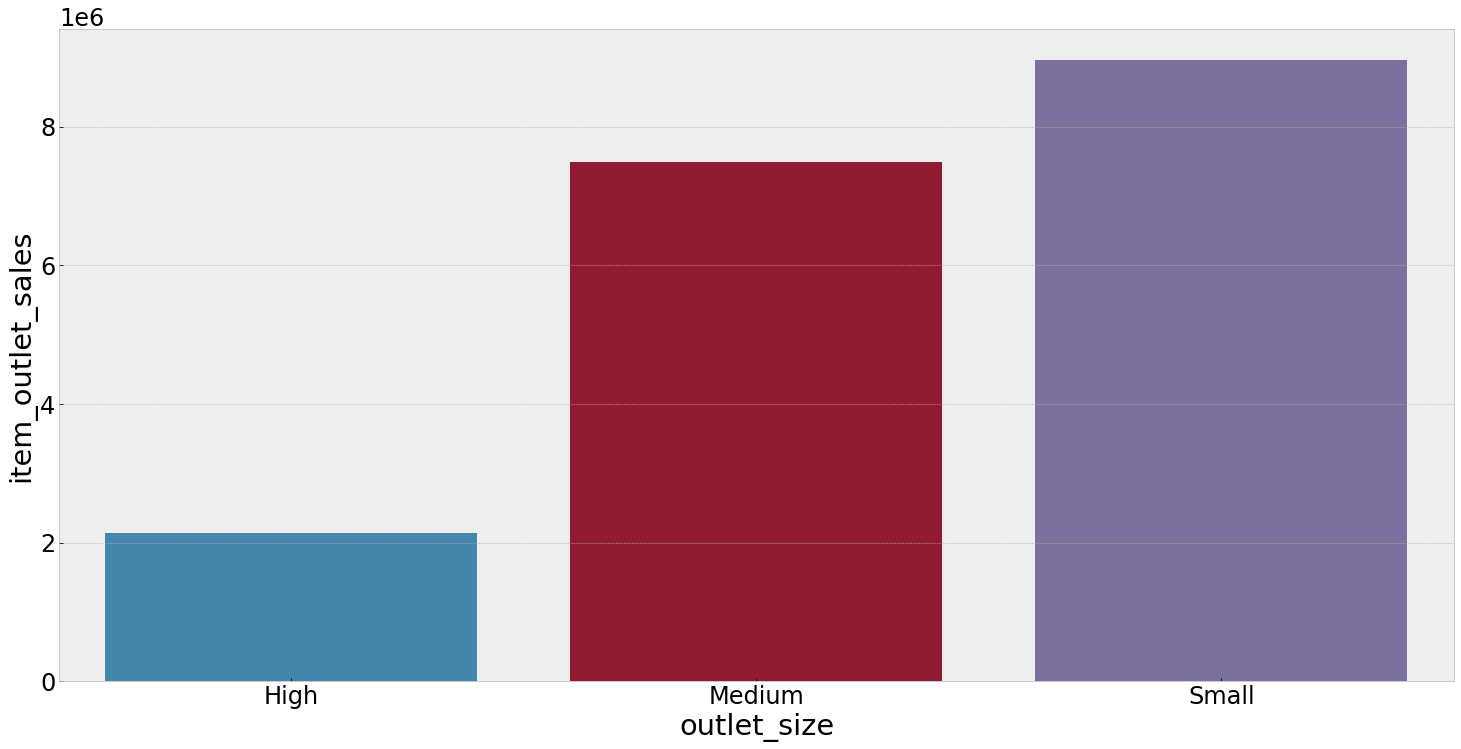

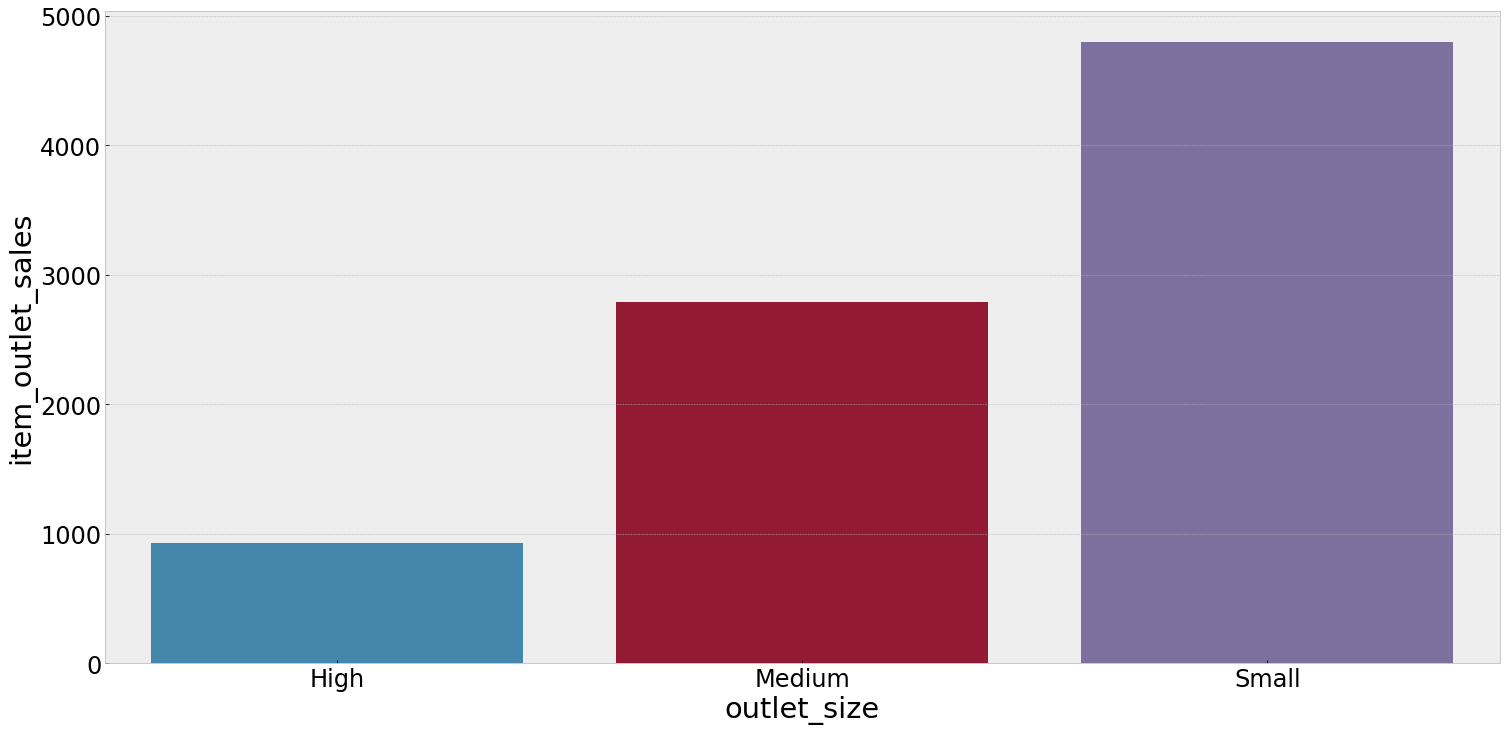

In [32]:
aux1 = df3[['outlet_size', 'item_outlet_sales']].groupby('outlet_size').sum().reset_index()
sns.barplot(x='outlet_size', y='item_outlet_sales', data=aux1);
plt.show()

aux1 = df3[['outlet_size', 'item_outlet_sales']].groupby('outlet_size').count().reset_index()
sns.barplot(x='outlet_size', y='item_outlet_sales', data=aux1);
plt.show()

### **H2** Tier 3 location outlets shoul sell more.
***TRUE*** Tier 3 location outlets sell more.

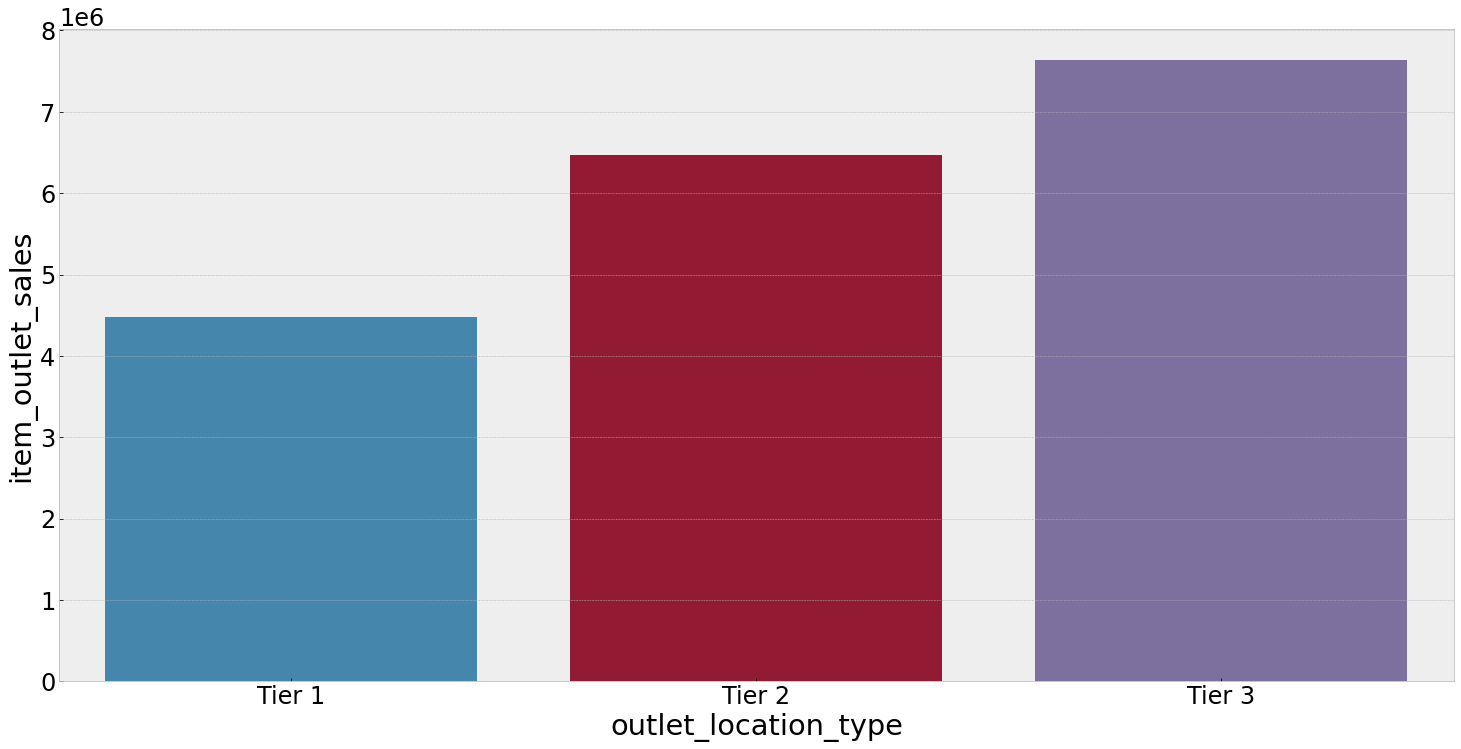

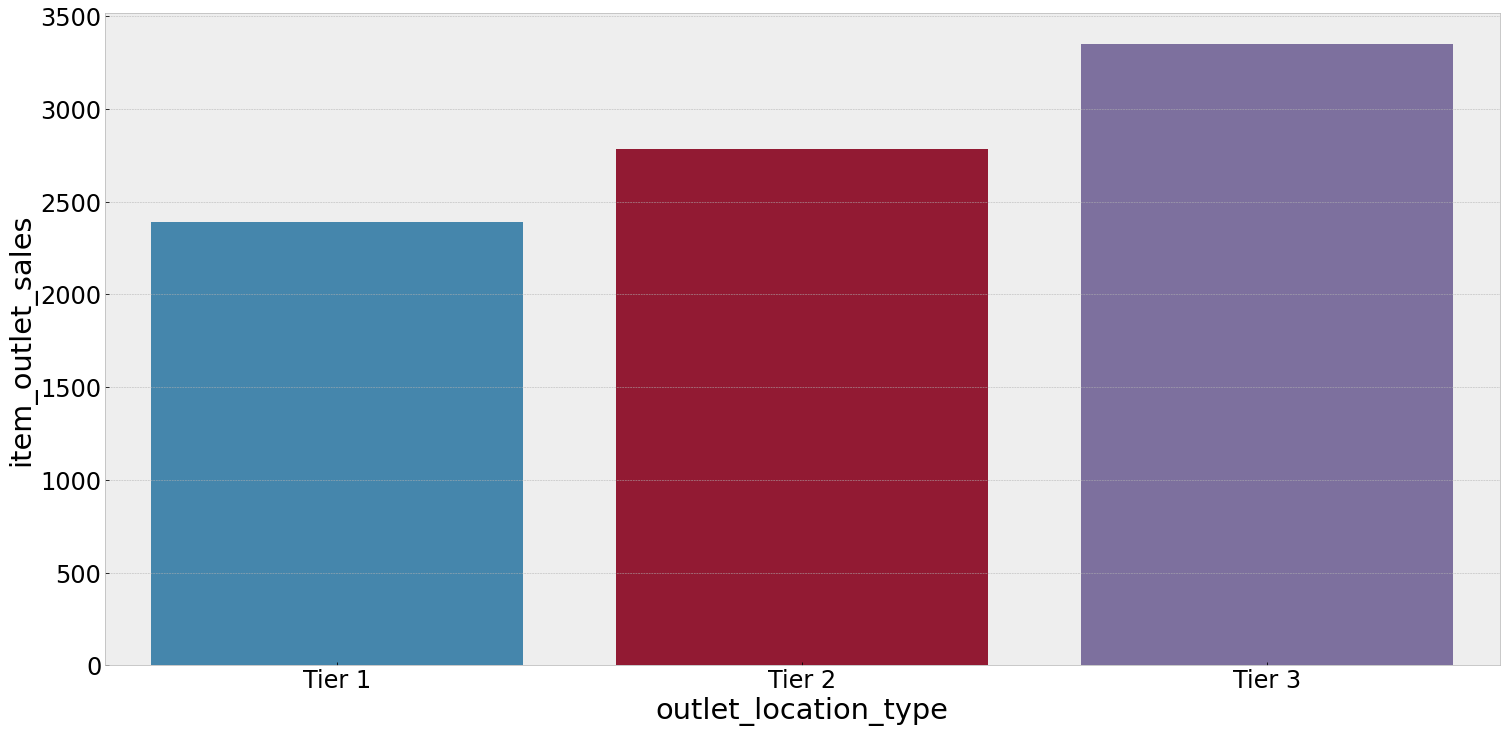

In [33]:
aux1 = df3[['outlet_location_type', 'item_outlet_sales']].groupby('outlet_location_type').sum().reset_index()
sns.barplot(x='outlet_location_type', y='item_outlet_sales', data=aux1);
plt.show()

aux1 = df3[['outlet_location_type', 'item_outlet_sales']].groupby('outlet_location_type').count().reset_index()
sns.barplot(x='outlet_location_type', y='item_outlet_sales', data=aux1);
plt.show()

### **H3** Supermarket Type1 is the outlet type with more sales.
***TRUE*** Supermarket Type1 is the outlet type with more sales.

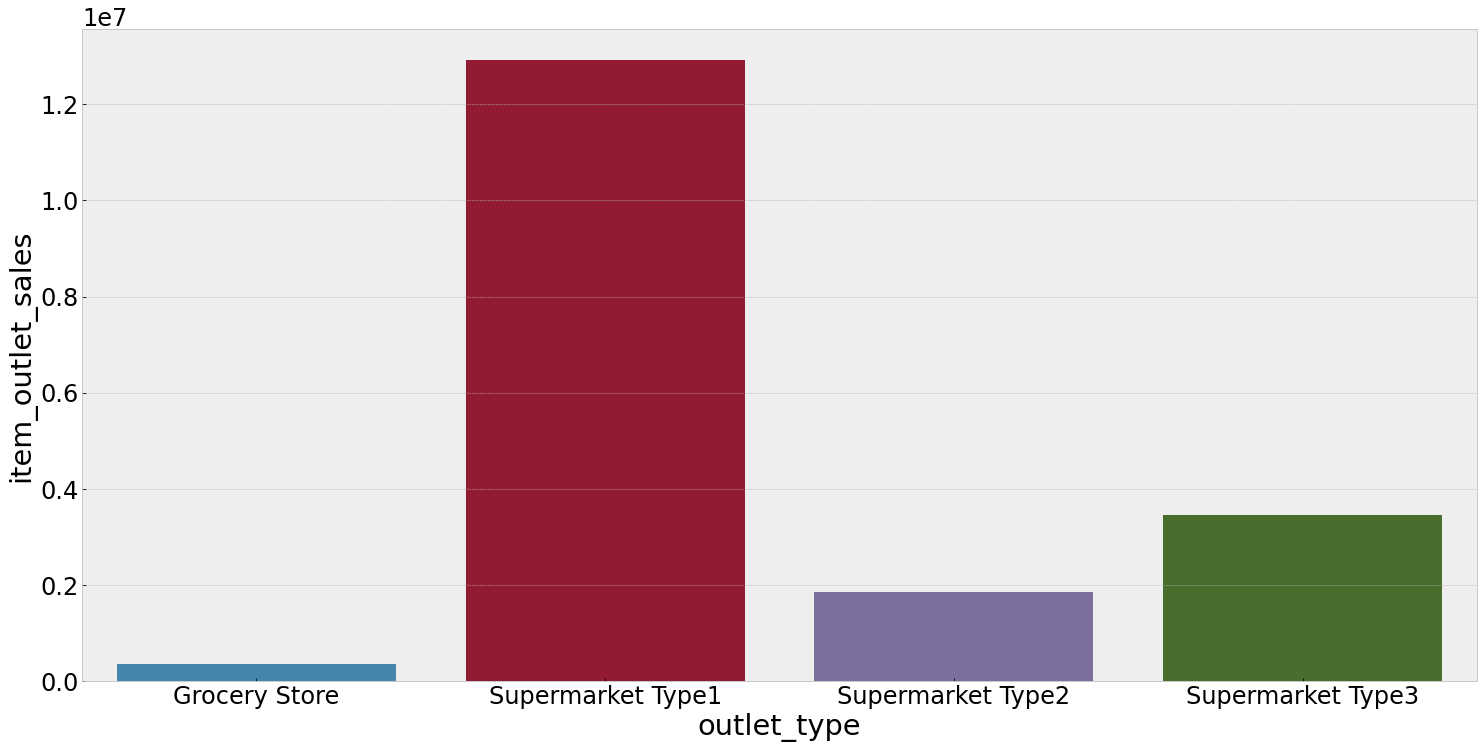

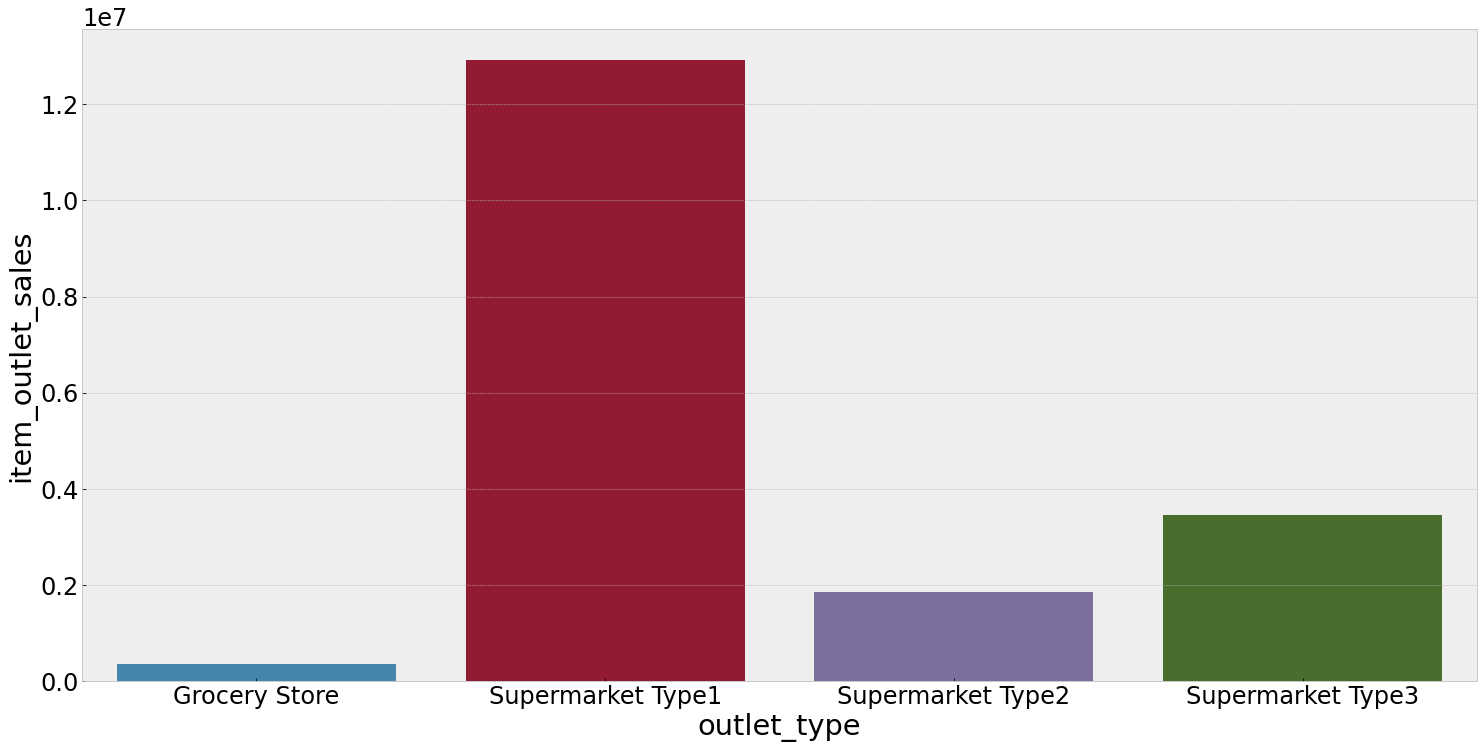

In [34]:
aux1 = df3[['outlet_type', 'item_outlet_sales']].groupby('outlet_type').sum().reset_index()
sns.barplot(x='outlet_type', y='item_outlet_sales', data=aux1);
plt.show()

aux2 = df3[['outlet_type', 'item_outlet_sales']].groupby('outlet_type').count().reset_index()
sns.barplot(x='outlet_type', y='item_outlet_sales', data=aux1);
plt.show()

### **H4** Older outlets should sell more.
***TRUE*** The oldest outlet is the one with more sales.

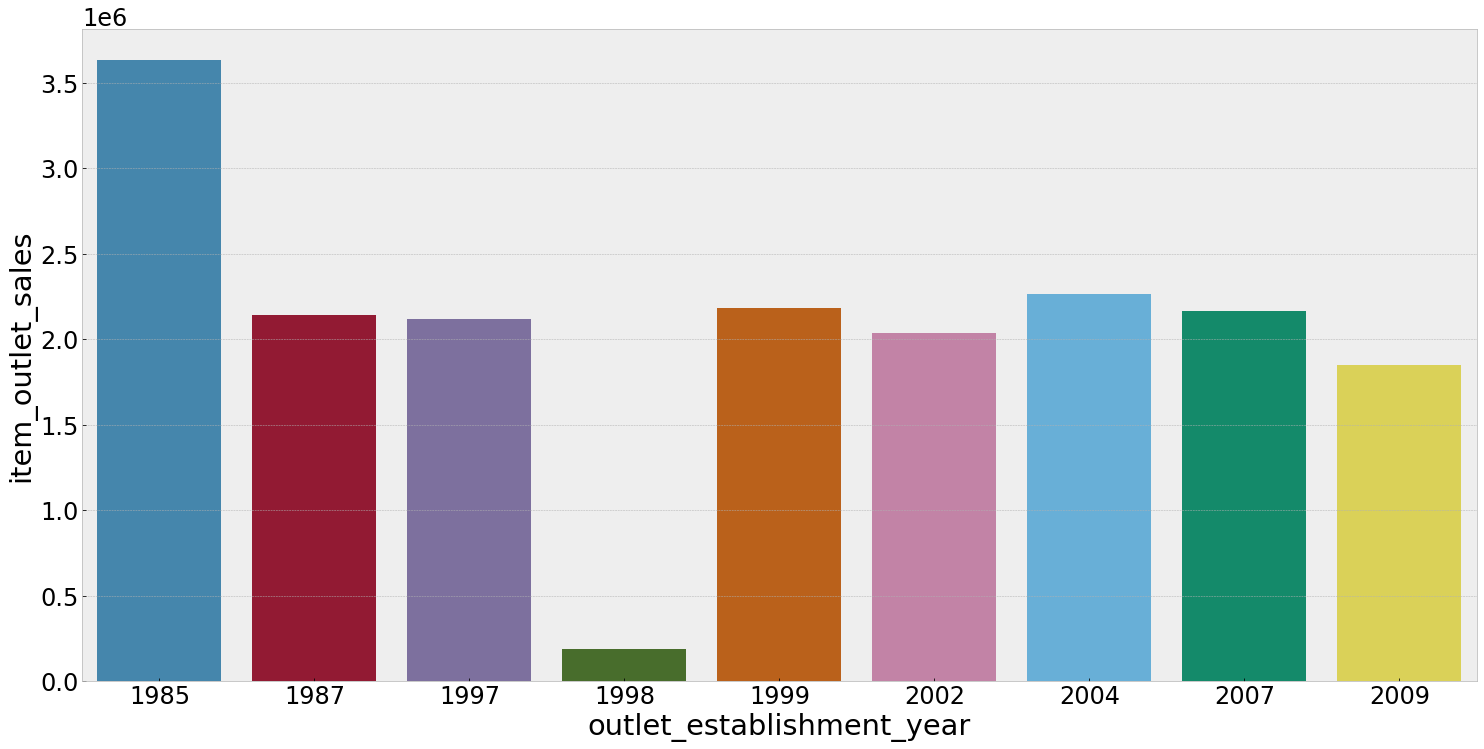

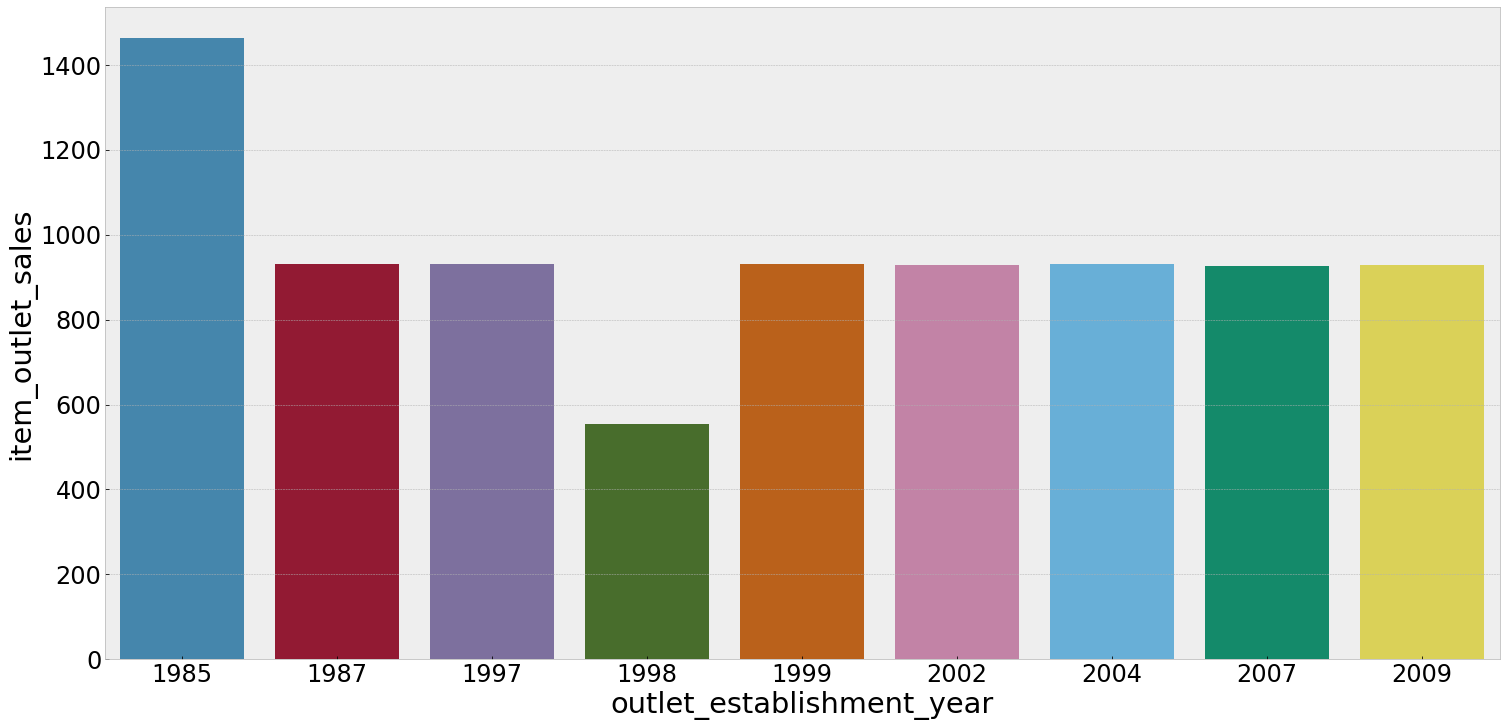

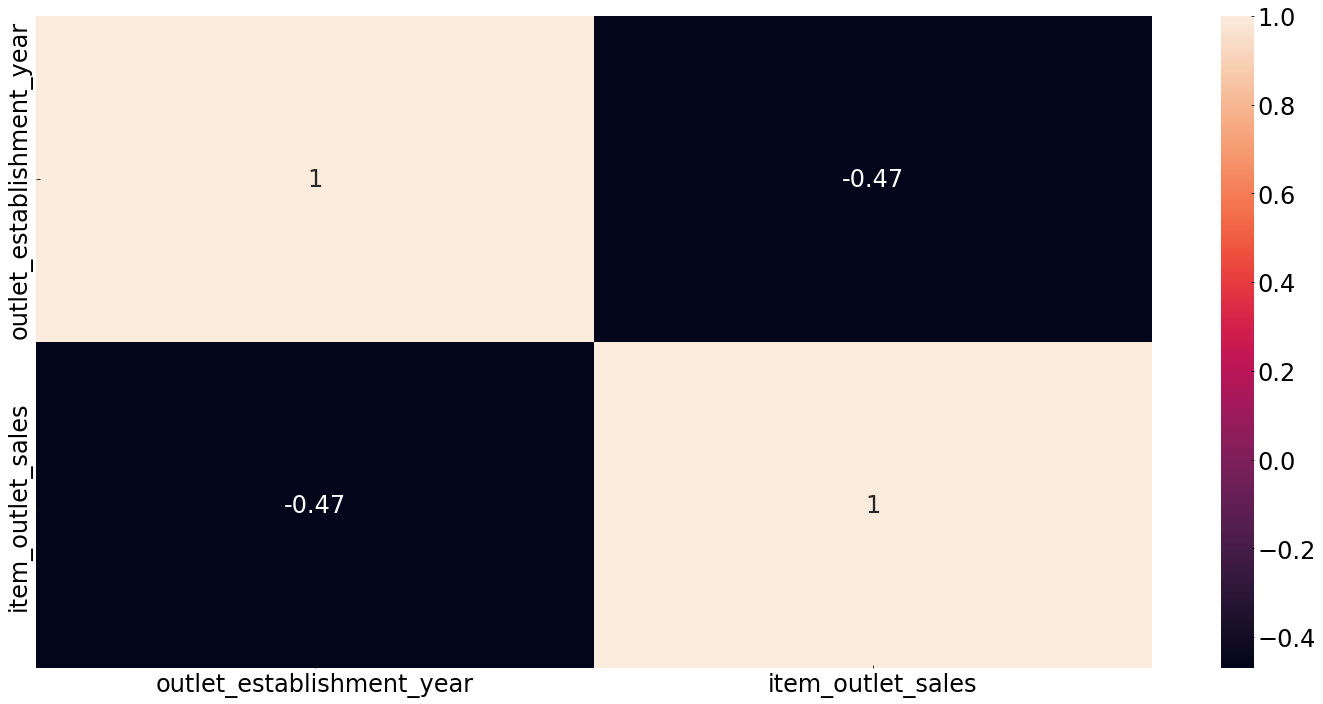

In [35]:
aux1 = df3[['outlet_establishment_year', 'item_outlet_sales']].groupby('outlet_establishment_year').sum().reset_index()
sns.barplot(x='outlet_establishment_year', y='item_outlet_sales', data=aux1);
plt.show()

aux1 = df3[['outlet_establishment_year', 'item_outlet_sales']].groupby('outlet_establishment_year').count().reset_index()
sns.barplot(x='outlet_establishment_year', y='item_outlet_sales', data=aux1);
plt.show()

sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

### **H5** Regular fat items should sell more.
***FALSE*** Low Fat items sells more.

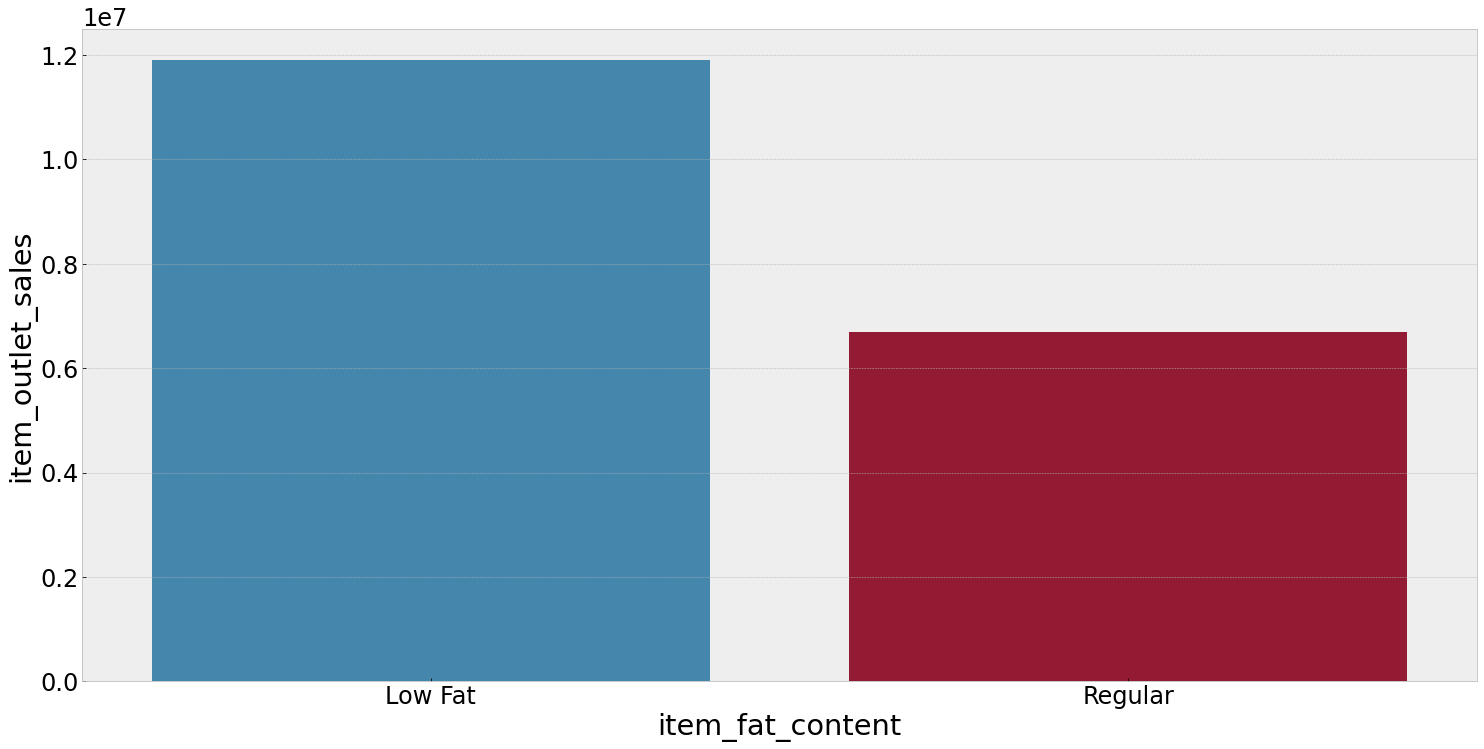

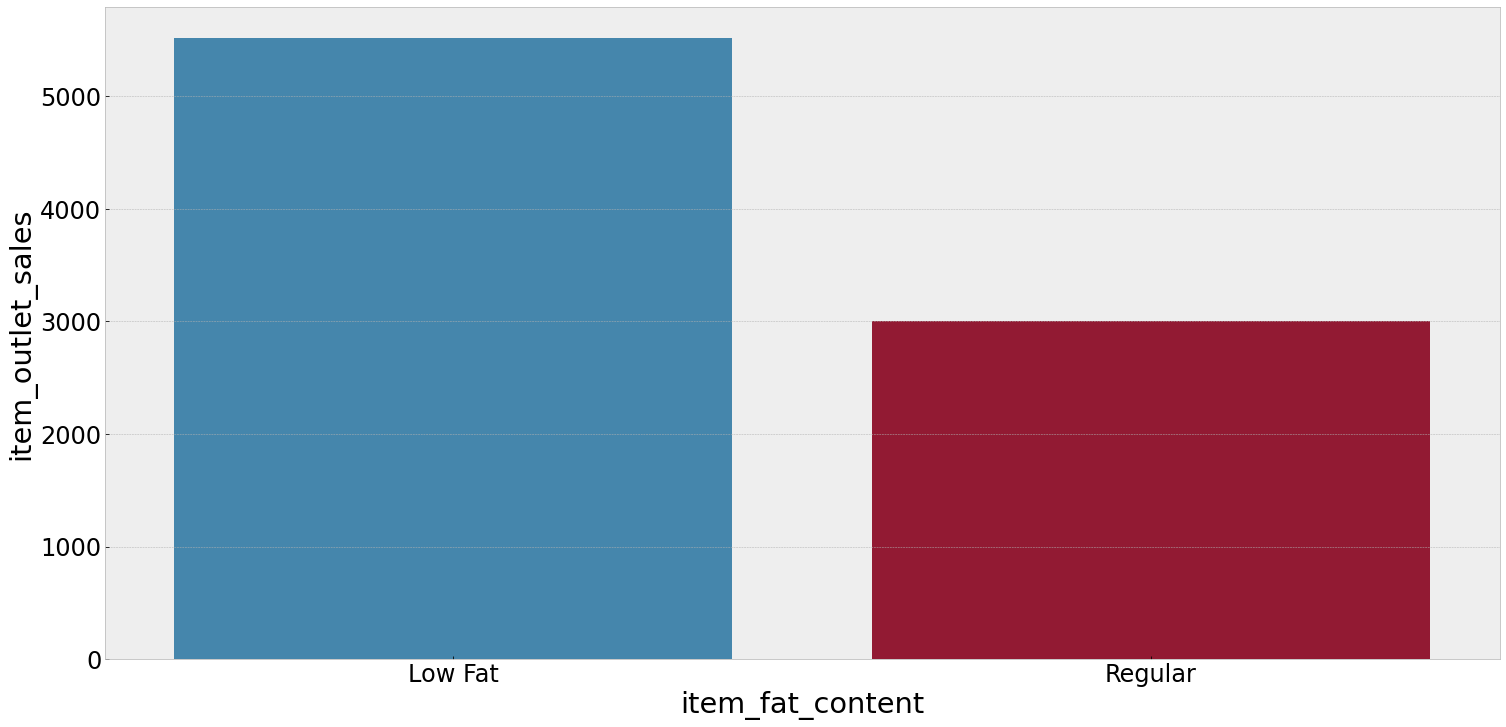

In [36]:
aux1 = df3[['item_fat_content', 'item_outlet_sales']].groupby('item_fat_content').sum().reset_index()
sns.barplot(x='item_fat_content', y='item_outlet_sales', data=aux1);
plt.show()

aux1 = df3[['item_fat_content', 'item_outlet_sales']].groupby('item_fat_content').count().reset_index()
sns.barplot(x='item_fat_content', y='item_outlet_sales', data=aux1);
plt.show()

### **H6** Items with bigger visibility should sell more.
***FALSE*** Items with less them 1% of visibility sells more (there are more products with less visibility then the ones with more).

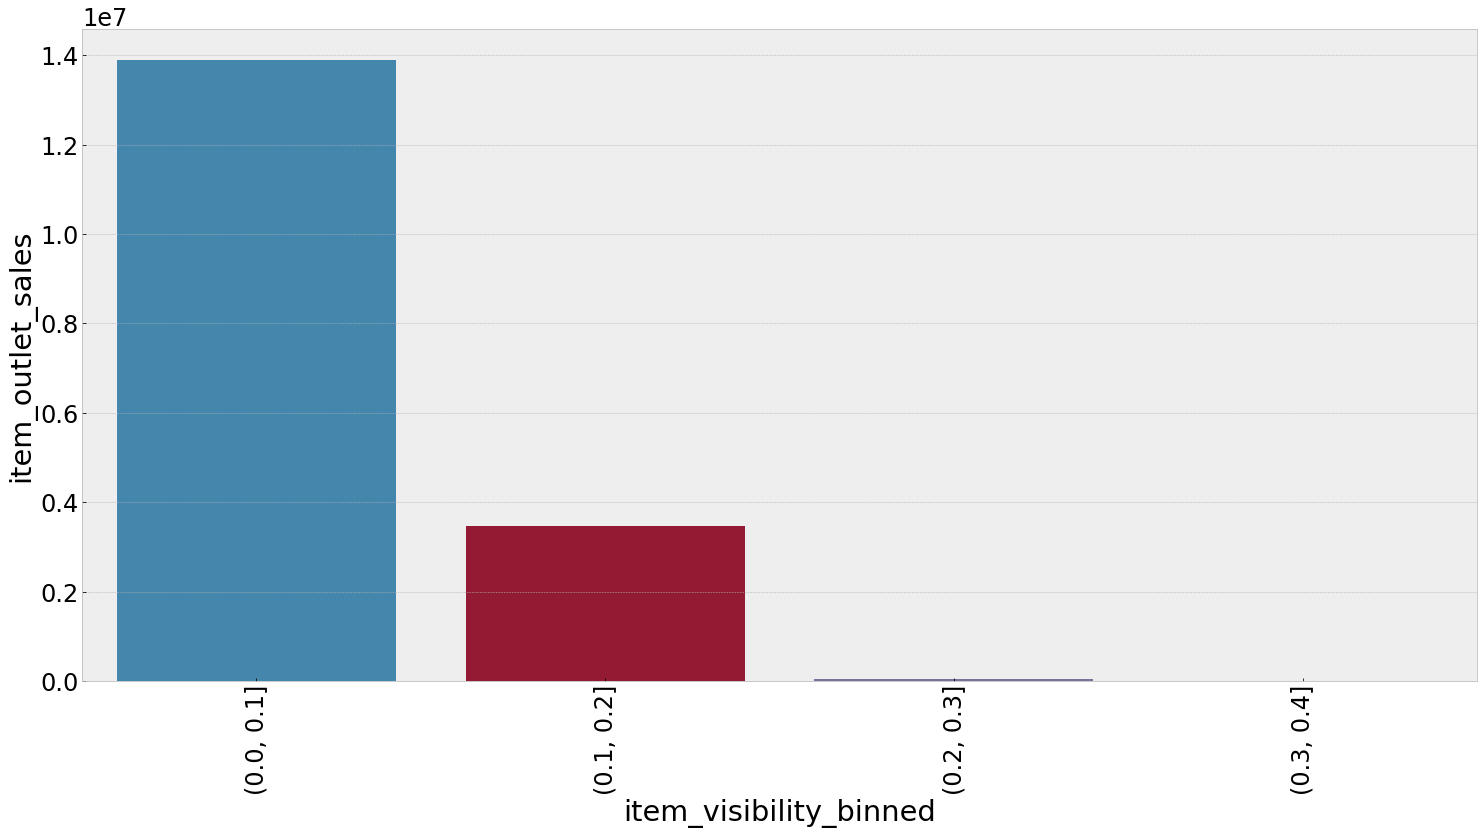

In [37]:
aux1 = df3[['item_visibility', 'item_outlet_sales']].groupby('item_visibility').sum().reset_index()
bins = list(np.arange(0, 0.5, 0.1))
aux1['item_visibility_binned'] = pd.cut(aux1['item_visibility'], bins=bins)
aux2 = aux1[['item_visibility_binned', 'item_outlet_sales']].groupby('item_visibility_binned').sum().reset_index()
sns.barplot(x='item_visibility_binned', y='item_outlet_sales', data=aux2);
plt.xticks(rotation=90);
plt.show()

In [38]:
aux2 = aux1[['item_visibility_binned', 'item_outlet_sales']].groupby('item_visibility_binned').count().reset_index()
aux2

,item_visibility_binned,item_outlet_sales
0,"(0.0, 0.1]",5986
1,"(0.1, 0.2]",1759
2,"(0.2, 0.3]",122
3,"(0.3, 0.4]",12


### **H7** Household items should be more expensive.
***TRUE*** Household items are more expensive.

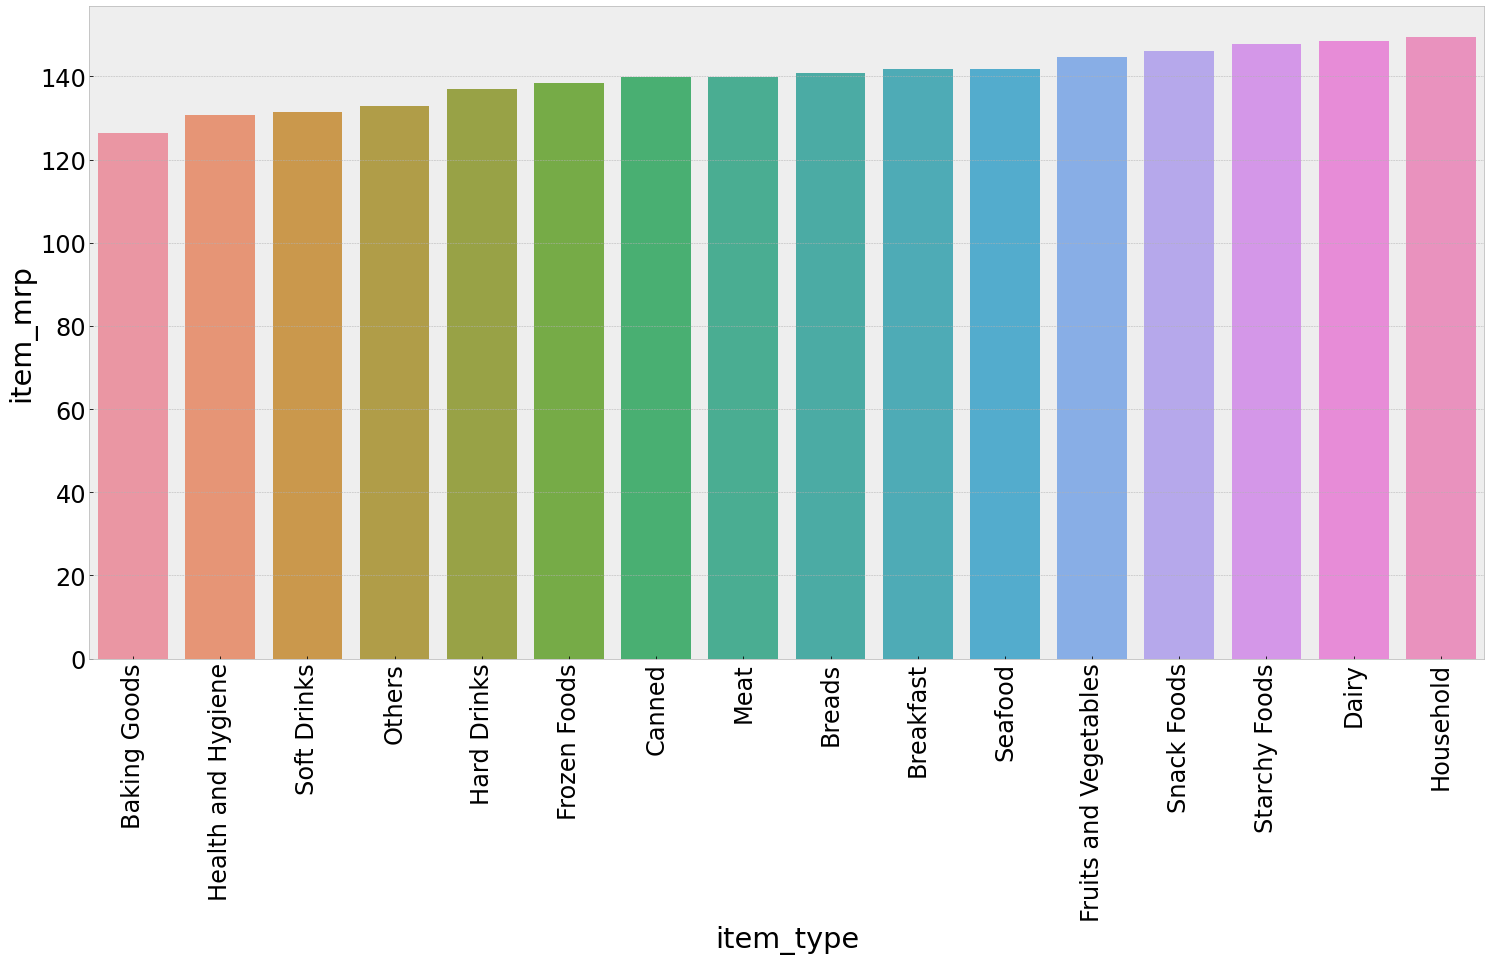

In [39]:
aux1 = df3[['item_type', 'item_mrp']].groupby('item_type').mean().reset_index().sort_values('item_mrp')
sns.barplot(x='item_type', y='item_mrp', data=aux1);
plt.xticks(rotation=90);
plt.show()

### **H8** Expensive products should sell less.
***FALSE*** Expensive items have a great number of sales.

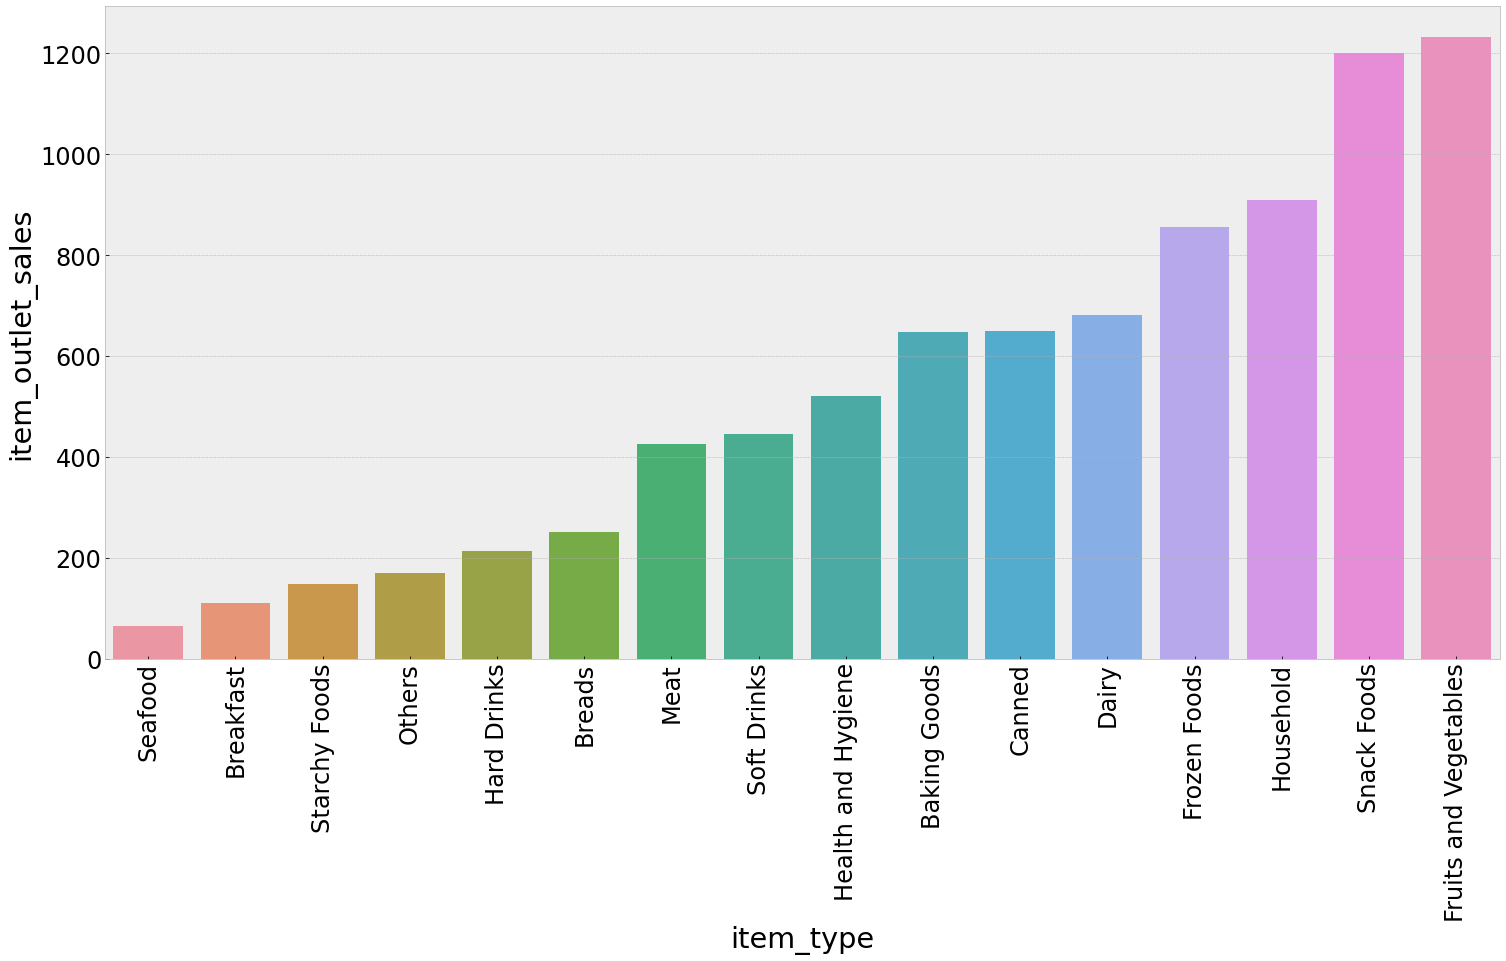

In [40]:
aux1 = df3[['item_type','item_outlet_sales']].groupby('item_type').count().reset_index().sort_values('item_outlet_sales')
sns.barplot(x='item_type', y='item_outlet_sales', data=aux1);
plt.xticks(rotation=90);
plt.show()

### **H9** Lighter items should cost less.
***FALSE*** Lighter items are not cheaper then heavier items.

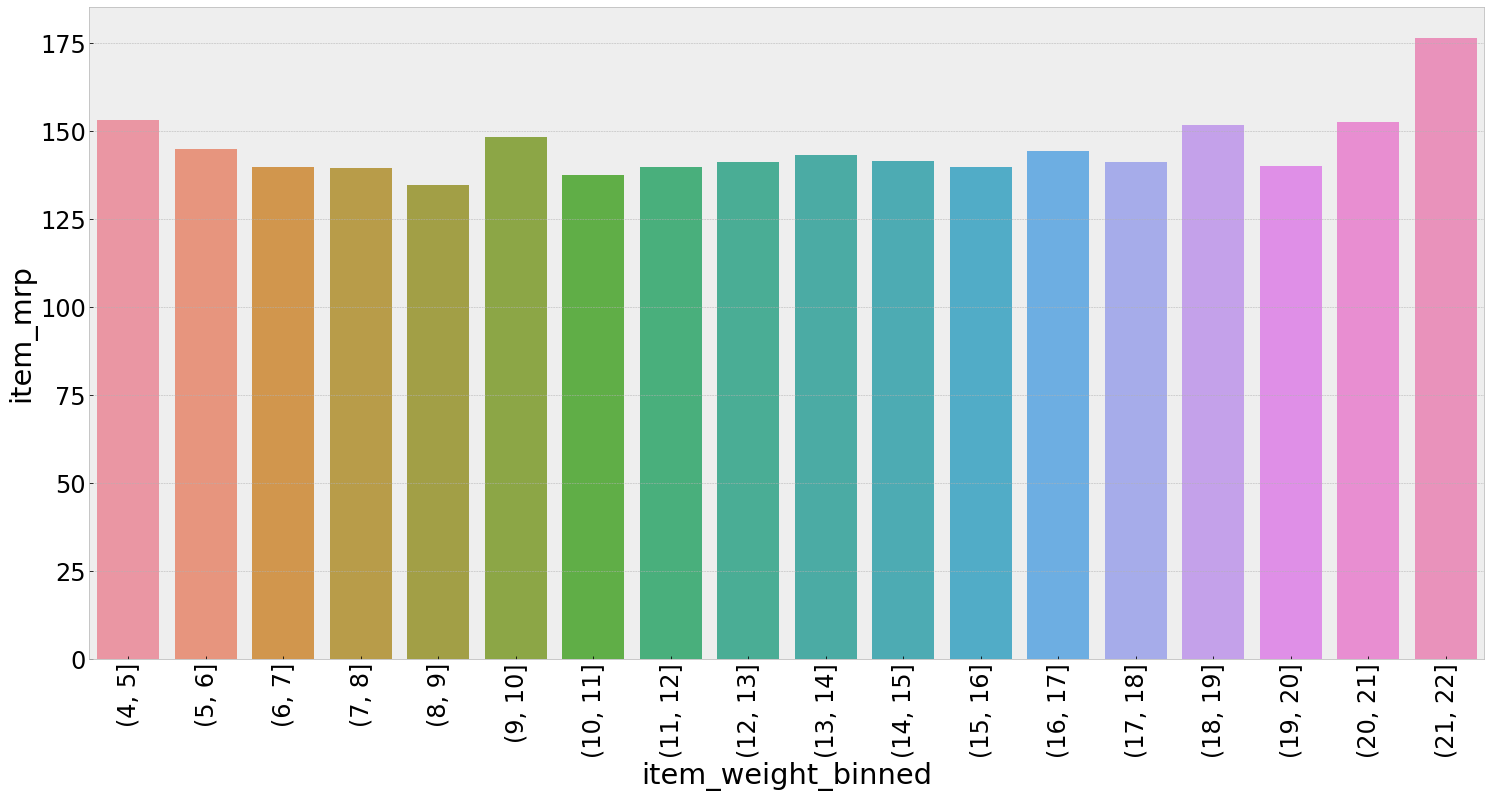

In [41]:
aux1 = df3[['item_weight', 'item_mrp']].groupby('item_mrp').mean().reset_index()
bins = list(np.arange(4, 23, 1))
aux1['item_weight_binned'] = pd.cut(aux1['item_weight'], bins=bins)
aux2 = aux1[['item_weight_binned', 'item_mrp']].groupby('item_weight_binned').mean().reset_index()
sns.barplot(x='item_weight_binned', y='item_mrp', data=aux2);
plt.xticks(rotation=90);
plt.show()

In [42]:
aux1 = df3[['item_weight', 'item_mrp']].groupby('item_weight').mean().reset_index()
bins = list(np.arange(4, 23, 1))
aux1['item_weight_binned'] = pd.cut(aux1['item_weight'], bins=bins)
aux2 = aux1[['item_weight_binned', 'item_mrp']].groupby('item_weight_binned').mean().reset_index()
aux2

,item_weight_binned,item_mrp
0,"(4, 5]",149.31
1,"(5, 6]",142.90
2,"(6, 7]",134.33
3,"(7, 8]",131.00
4,"(8, 9]",130.02
5,"(9, 10]",137.97
6,"(10, 11]",136.46
7,"(11, 12]",140.26
8,"(12, 13]",137.37
9,"(13, 14]",147.00


### **H10** Heavier items should sell less.
***TRUE*** Heavier items sell less then lighter items.

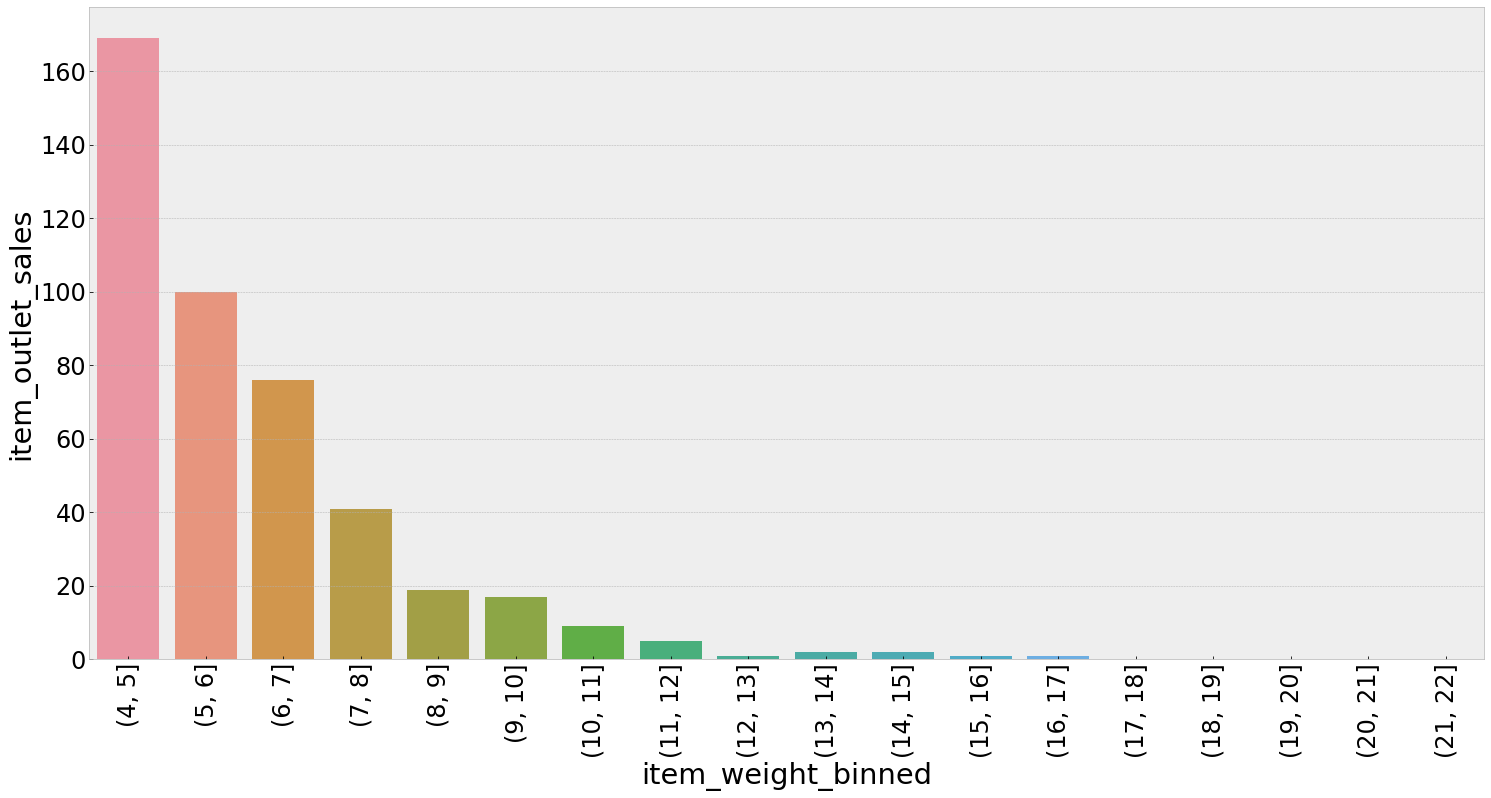

In [43]:
aux1 = df3[['item_weight', 'item_outlet_sales']].groupby('item_outlet_sales').count().reset_index()
bins = list(np.arange(4, 23, 1))
aux1['item_weight_binned'] = pd.cut(aux1['item_weight'], bins=bins)
aux2 = aux1[['item_weight_binned', 'item_outlet_sales']].groupby('item_weight_binned').count().reset_index()
sns.barplot(x='item_weight_binned', y='item_outlet_sales', data=aux2);
plt.xticks(rotation=90);
plt.show()

### 3.2.1 Hypothesis Resume

In [64]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'High'],
      ['H2', 'True', 'High'],
      ['H3', 'True', 'High'],
      ['H4', 'True', 'High'],
      ['H5', 'False', 'Low'],
      ['H6', 'False', 'High'],
      ['H7', 'True', 'Low'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'Low'],
      ['H10', 'True', 'Low'],
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         High
H2            True          High
H3            True          High
H4            True          High
H5            False         Low
H6            False         High
H7            True          Low
H8            False         High
H9            False         Low
H10           True          Low


## 3.3 Multivariable Analysis 

### 3.3.1 Numerical Attributes 

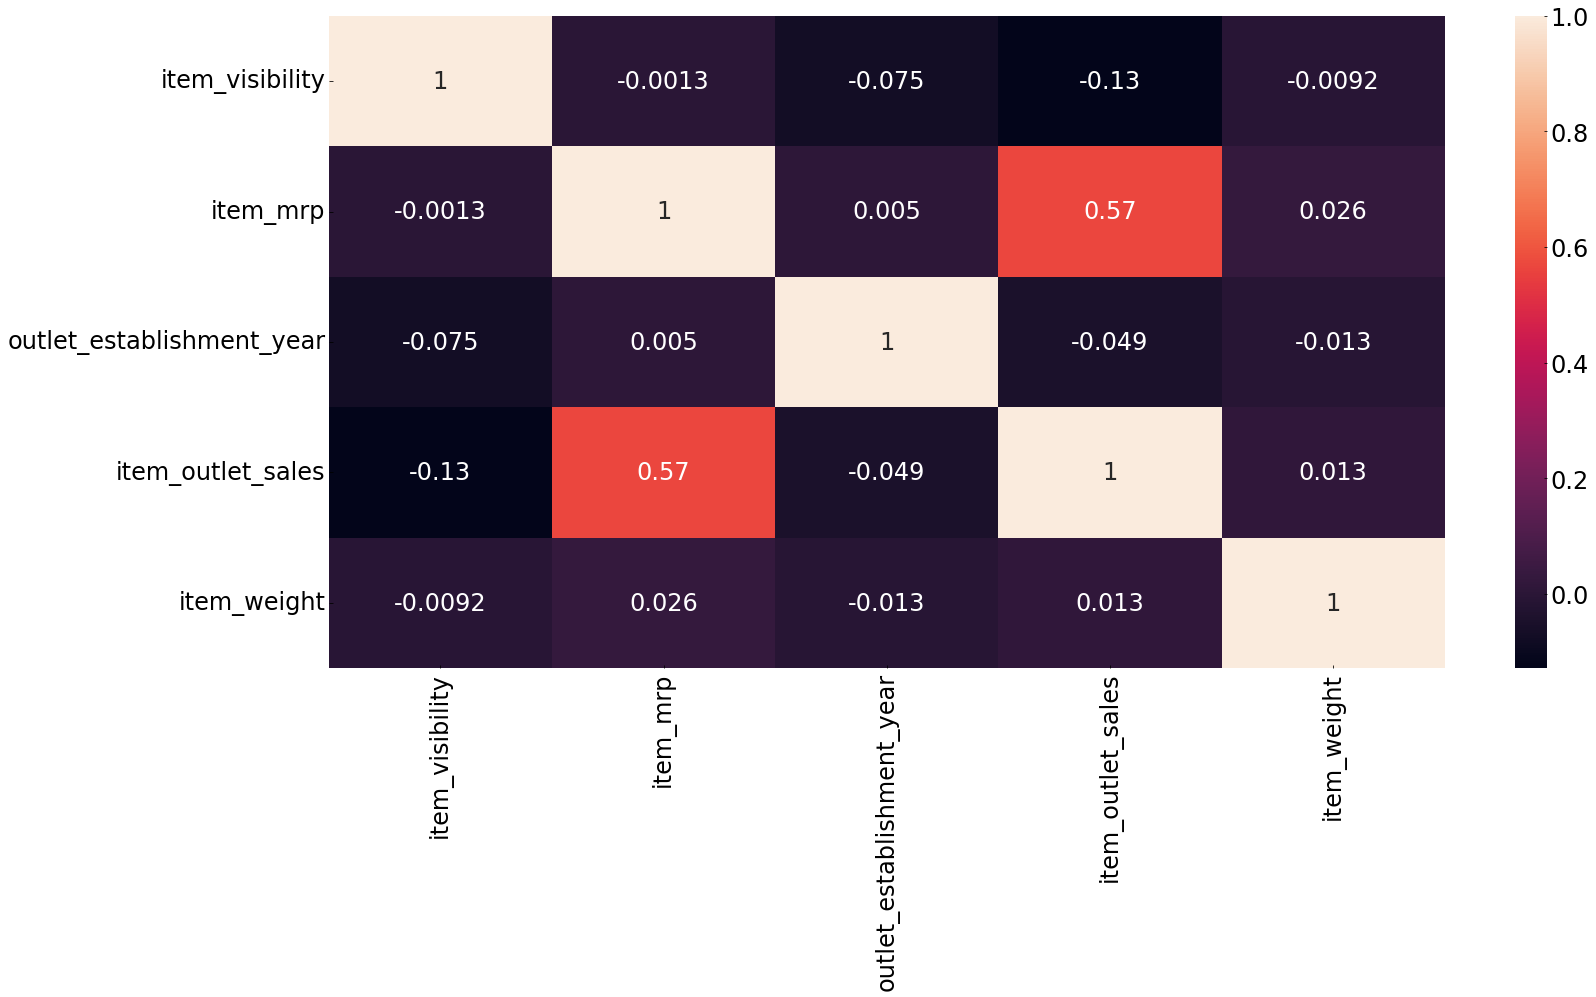

In [44]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 3.3.2 Categorical Attributes 

In [45]:
a = df3.select_dtypes(include='object')

In [46]:
a1 = cramer_v(a['item_fat_content'], a['item_fat_content'])
a2 = cramer_v(a['item_fat_content'], a['item_type'])
a3 = cramer_v(a['item_fat_content'], a['outlet_size'])
a4 = cramer_v(a['item_fat_content'], a['outlet_location_type'])
a5 = cramer_v(a['item_fat_content'], a['outlet_type'])

a6 = cramer_v(a['item_type'], a['item_fat_content'])
a7 = cramer_v(a['item_type'], a['item_type'])
a8 = cramer_v(a['item_type'], a['outlet_size'])
a9 = cramer_v(a['item_type'], a['outlet_location_type'])
a10 = cramer_v(a['item_type'], a['outlet_type'])

a11 = cramer_v(a['outlet_size'], a['item_fat_content'])
a12 = cramer_v(a['outlet_size'], a['item_type'])
a13 = cramer_v(a['outlet_size'], a['outlet_size'])
a14 = cramer_v(a['outlet_size'], a['outlet_location_type'])
a15 = cramer_v(a['outlet_size'], a['outlet_type'])

a16 = cramer_v(a['outlet_location_type'], a['item_fat_content'])
a17 = cramer_v(a['outlet_location_type'], a['item_type'])
a18 = cramer_v(a['outlet_location_type'], a['outlet_size'])
a19 = cramer_v(a['outlet_location_type'], a['outlet_location_type'])
a20 = cramer_v(a['outlet_location_type'], a['outlet_type'])

a21 = cramer_v(a['outlet_type'], a['item_fat_content'])
a22 = cramer_v(a['outlet_type'], a['item_type'])
a23 = cramer_v(a['outlet_type'], a['outlet_size'])
a24 = cramer_v(a['outlet_type'], a['outlet_location_type'])
a25 = cramer_v(a['outlet_type'], a['outlet_type'])



d = pd.DataFrame({'item_fat_content': [a1, a2, a3, a4, a5],
                 'item_type': [a6, a7, a8, a9, a10],
                 'outlet_size': [a11, a12, a13, a14, a15],
                 'outlet_location_type': [a16, a17, a18, a19, a20],
                 'outlet_type': [a21, a22, a23, a24, a25]})
d = d.set_index(d.columns)

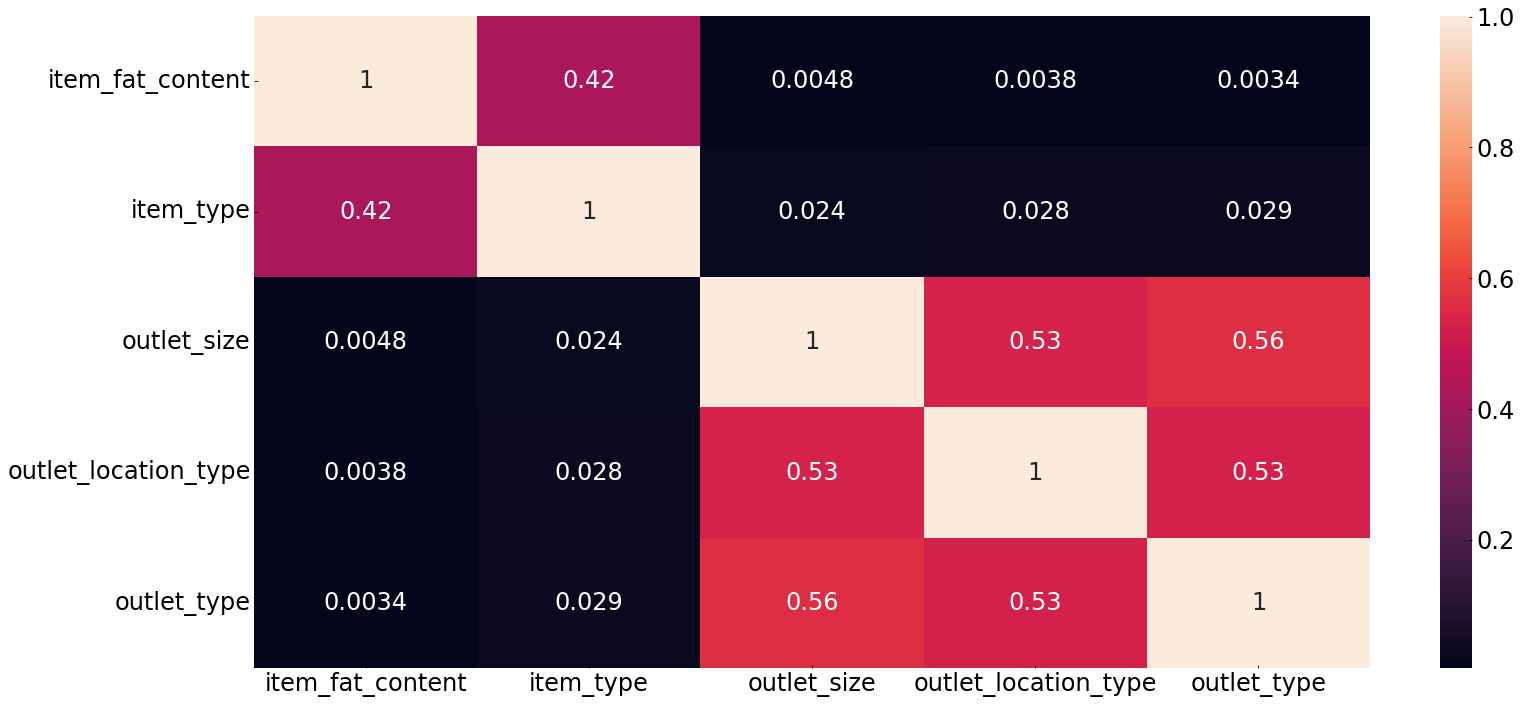

In [47]:
sns.heatmap(d, annot=True);

# 4.0 - DATA PREPARATION

In [48]:
df4 = df3.copy()

## 4.1 Rescaling 

In [49]:
mms = MinMaxScaler()

#item_visibility
df4['item_visibility'] = mms.fit_transform(df4[['item_visibility']].values)
#item_mrp
df4['item_mrp'] = mms.fit_transform(df4[['item_mrp']].values)
#item_weight
df4['item_weight'] = mms.fit_transform(df4[['item_weight']].values)
#outlet_establishment_year
df4['outlet_year'] = mms.fit_transform(df4[['outlet_establishment_year']].values)

## 4.2 Transformation

###  4.2.1 Enconding

In [50]:
le = LabelEncoder()

#item_identifier - label enconding
df4['item_identifier'] = le.fit_transform(df4['item_identifier'])

#item_fat_content - one hot enconding
df4 = pd.get_dummies(df4, prefix=['item_fat_content'], columns=['item_fat_content'])

#item_type - label enconding
type_dict = {'Dairy': 1,
             'Soft Drinks': 2, 
             'Meat': 3, 
             'Fruits and Vegetables': 4,
             'Household': 5, 
             'Baking Goods': 6, 
             'Snack Foods': 7, 
             'Frozen Foods': 8,
             'Breakfast': 9, 
             'Health and Hygiene': 10, 
             'Hard Drinks': 11, 
             'Canned': 12,
             'Breads': 13, 
             'Starchy Foods': 14, 
             'Others': 15, 
             'Seafood': 16}
df4['item_type'] = df4['item_type'].map(type_dict)

#outlet_size - ordinal enconding
size_dict = {'Small': 0, 'Medium': 1, 'High': 2}
df4['outlet_size'] = df4['outlet_size'].map(size_dict)

#outlet_location_type - label enconding
df4['outlet_location_type'] = le.fit_transform(df4['outlet_location_type'])

#outlet_type - label enconding 
df4['outlet_type'] = le.fit_transform(df4['outlet_type'])

###  4.2.2 Response Variable Transformation

In [51]:
df4['item_outlet_sales'] = np.log1p(df4['item_outlet_sales'])

# 5.0 - FEATURE SELECTION

In [52]:
df5 = df4.copy()

In [53]:
cols_drop = ['outlet_identifier', 'outlet_establishment_year']
df5 = df5.drop(cols_drop, axis=1)

## 5.1 Split dataframe into training and test

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df5, df5['item_outlet_sales'], train_size=0.8)

## 5.2 Boruta as feature selector 

In [55]:
#training and test dataset for Boruta
X_train_n = X_train.drop(['item_outlet_sales'], axis=1).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	10


### 5.2.1 Best features from Boruta 

In [56]:
#cols_selected = boruta.support_.tolist()
#features selected
X_train_fs = X_train.drop(['item_outlet_sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#not selected
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 5.3 Manual feature selection 

In [65]:
cols_selected_boruta = ['item_mrp', 'outlet_type', 'outlet_size', 'outlet_id', 'item_identifier', 'outlet_location_type', 'item_visibility', 'outlet_year']

#columns to add
feat_to_add = ['item_outlet_sales']

#final features
cols_selected_boruta.extend(feat_to_add)

In [67]:
cols_selected_boruta

['item_mrp',
 'outlet_type',
 'outlet_size',
 'outlet_id',
 'item_identifier',
 'outlet_location_type',
 'item_visibility',
 'outlet_year',
 'item_outlet_sales']